# Ad break detection and contextual Ad targeting

Contextual advertising is a form of targeted advertising where the advertisement is matched to the context of the webpage or media being consumed by the user. This process involves three key players: the publisher (website or content owner), the advertiser, and the consumer. Publishers provide the platform and content, while advertisers create ads tailored to the context. Consumers engage with the content, and relevant ads are displayed based on the context, creating a more personalized and relevant advertising experience.



A challenging area of contextual advertising is inserting ads in media content for streaming on video on demand (VOD) platforms. This process traditionally relied on manual tagging, where human experts analyzed the content, identified breaks in the narrative and assigned relevant keywords or categories. However, this approach is time-consuming, subjective, and may not capture the full context or nuances of the content. Traditional AI/ML solutions can automate this process, but they often require extensive training data and can be expensive and limited in their capabilities.

![Ad decisions](./static/images/02-ad-breaks.png)

Generative AI, powered by large language models, offers a promising solution to this challenge. By leveraging the vast knowledge and contextual understanding of these models, publishers can automatically generate contextual insights and taxonomies for their media assets. This approach streamlines the process and provides accurate and comprehensive contextual understanding, enabling effective ad targeting and monetization of media archives.

When you are done with this part of the workshop, you'll have created the following metadata for a video:
* a list of high quality ad placement opportunities  or _breaks_ available in the video
* contextual information for the video before and after each break, including classification using the IAB Content Taxonomy that is used by advertisers to classify content for automated placement using Ad Decision Servers.

# Prerequisites

To run this notebook, you need to have run all the previous foundation notebooks, where you set up the notebook environment and segmented the video using audio, visual and semantic information:
1. [00-prerequisites.ipynb](00-prerequisites.ipyn)
2. [01A-visual-segments-frames-shots-scenes.ipynb](01A-visual-segments-frames-shots-scenes.ipynb) 
3. [01B-audio-segments.ipynb](01B-audio-segments.ipynb)

### Import python packages

In [1]:
from pathlib import Path
import os
import json
import json
import boto3
from botocore.exceptions import ClientError
import json_repair
import copy
from termcolor import colored
from IPython.display import JSON
from IPython.display import Video
from IPython.display import Pretty
from IPython.display import Image as DisplayImage
from lib.frames import VideoFrames
from lib.shots import Shots
from lib.scenes import Scenes
from lib.transcript import Transcript
#from lib.chapters import Chapters
from lib import frame_utils
from lib import util
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
import copy
import time

### Retrieve saved values from previous notebooks
To run this notebook, you need to have run the previous notebook: 00_prerequisites.ipynb, where you installed package dependencies and gathered some information from the SageMaker environment.




In [2]:
store -r

# Architecture

This hands-on workflow uses AWS services from SageMaker.  It takes scenes, conversation topics and advertising content taxonomies as inputs and produces contextual ad breaks and chapter segments as outputs.


![Contextual Ads workflow with outputs](./static/images/02-contextual-ads-workflow-w-outputs-drawio.png)


# Find ad placement opportunities by aligning scenes and topics to identify chapters in the narrative

In the [Video segmentation notebook](video-understanding-with-generative-ai-on-aws-main/01-video-time-segmentation.ipynb), we have separately processed the visual and audio cues from the video. Now, we will do one more step to bring them together and ensure that the transcription topics align with the scenes. The last thing you want is to insert an ad during an ongoing conversation or scene. To create alignment, we will iterate over each conversational topic, represented by its start and end timestamps, and a text description summarizing the topic. For each topic, the code identifies the relevant video scenes that overlap or fall within the topic's timestamp range. The output of this process is a list of chapters, where each chapter contains a list of scene IDs representing the video scenes that align with the corresponding audio conversation. After the alignment process, we have combined visual and audio cues into the final chapters. The breaks between chapters are ideal places for ad insertion because they occur between contextual changes in the content of the video. 

In real-world applications, we recommend surfacing these breaks as suggestions to the operator and having a human-in-the-loop step to confirm the final ad placements.

In [3]:
class Chapters:
    def __init__(self, topics, scenes, frames):
        self.video_asset_dir = frames.video_asset_dir()
        self.chapters = self.align_scenes_in_chapters(topics, scenes, frames)
        
    def align_scenes_in_chapters(self, topics, scenes, frames):
        """
        Aligns video scenes with conversation topics to create chronological chapters.
    
        Args:
            topics: List of conversation topics with start_ms, end_ms, and reason
            scenes: List of scene metadata with start_ms and end_ms
            frames: List of video frame metadata
    
        Returns:
            List of chapters, each containing aligned scenes and associated text
    
        Note:
            - Handles scenes without conversations
            - Merges overlapping topics
            - Preserves chronological order
            - Creates Chapter objects for each segment
    """
        scenes = copy.deepcopy(scenes)
    
        chapters = []
        for topic in topics:
            
            topic_start_ms = topic['start_ms']
            topic_end_ms = topic['end_ms']
            text = topic['reason']

            # find all the frames that align with the conversation topic
            stack = []
            while len(scenes) > 0:
                scene = scenes[0]
                frame_start = scene['start_ms']
                frame_end = scene['end_ms']

                
                if frame_start > topic_end_ms:
                    # topic overlaps scenes that belong to previous topic - merge the text
                    if not stack:
                        num_chapters = len(chapters)
                        if num_chapters > 0:
                            chapters[num_chapters-1]['text'] = chapters[num_chapters-1]['text'] + ' ' + text
                        
                    break
    
                # scenes before any conversation starts
                if frame_end < topic_start_ms:
                    chapter = Chapter(len(chapters), [scene], frames).__dict__
                    chapters.append(chapter)
                    scenes.pop(0)
                    continue
    
                stack.append(scene)
                scenes.pop(0)
    
            if stack:
                chapter = Chapter(len(chapters), stack, frames, text).__dict__
                chapters.append(chapter)
    
        ## There could be more scenes without converations, append them
        for scene in scenes:
            chapter = Chapter(len(chapters), [scene], frames).__dict__
            chapters.append(chapter)
    
        return chapters

class Chapter:
    def __init__(self, chapter_id, scenes, frames, text = ''):
        self.scene_ids = [scene['id'] for scene in scenes]
        self.start_frame_id = scenes[0]['start_frame_id']
        self.end_frame_id = scenes[-1]['end_frame_id']
        self.start_ms = scenes[0]['start_ms']
        self.end_ms = scenes[-1]['end_ms']
        self.id = chapter_id
        self.text = text
        #folder = os.path.join(frames.video_asset_dir(), 'chapters')
        #os.makedirs(folder, exist_ok=True) 
        self.composite_images = frames.create_composite_images(frames.frames[self.start_frame_id:self.end_frame_id+1], 'chapters', prefix="chapter_")
        
        return 


In [4]:
video['chapters'] = Chapters(video['topics'], video['scenes'].scenes, video['frames'])

Examine the results

In [5]:
display(JSON(video['chapters'].chapters))

<IPython.core.display.JSON object>

#### Visualize the chapters

Now let's visualize the frames and the text for each of the chapters.  These will be the input to our prompt to generate contextual information for the ad breaks. Note that some chapters will not have any text associated with them.

<div class="alert alert-block alert-info">
💡 Use the scroll bar in the output box to view the chapters.  Some chapters contain more frames than can fit on a single composite image, so the may be multiple composite images displayed for each chapter.
</div>



Chapter 0: frames 0 to 0, scenes 0 to 0, time 0 to 967 =======


Chapter Text (conversation topic): None


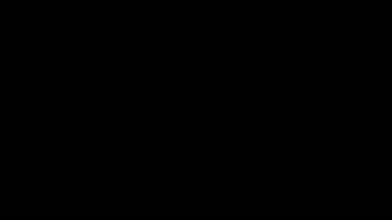


Chapter 1: frames 2 to 15, scenes 1 to 1, time 1001 to 15615 =======


Chapter Text (conversation topic): None


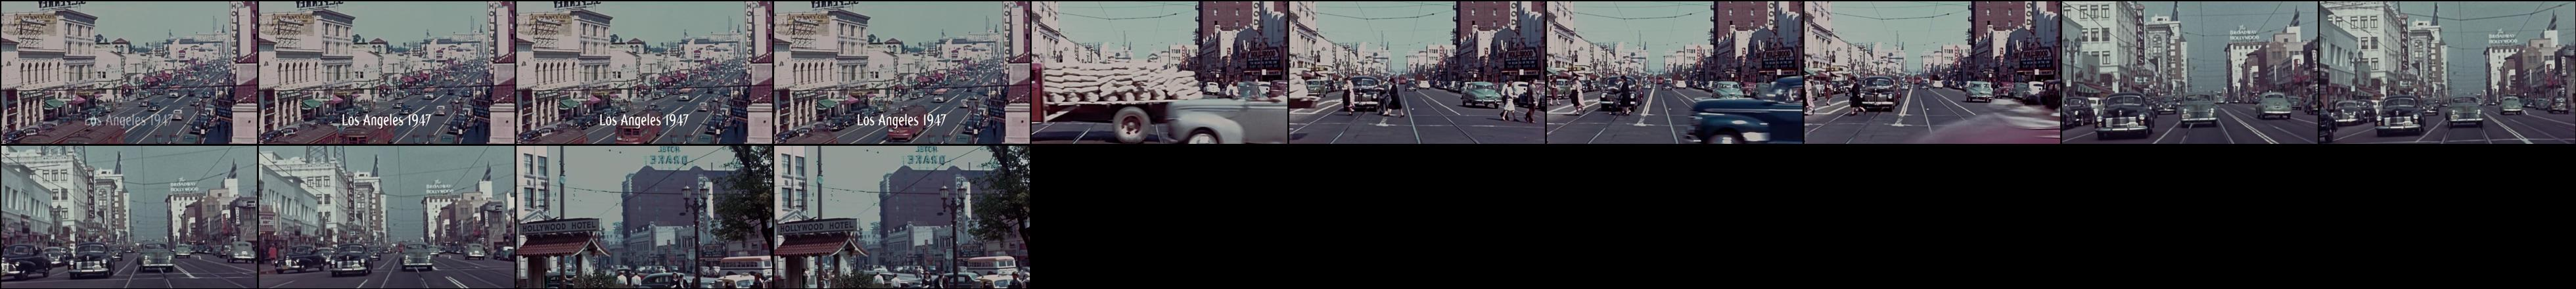


Chapter 2: frames 16 to 17, scenes 2 to 2, time 15648 to 17550 =======


Chapter Text (conversation topic): None


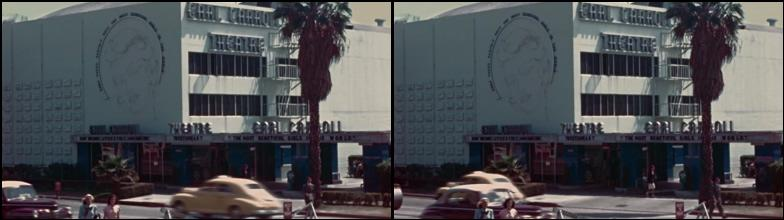


Chapter 3: frames 18 to 20, scenes 3 to 3, time 17584 to 20120 =======


Chapter Text (conversation topic): None


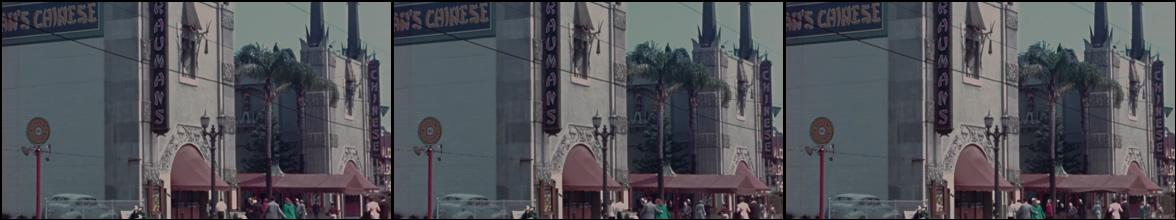


Chapter 4: frames 21 to 23, scenes 4 to 4, time 20153 to 23056 =======


Chapter Text (conversation topic): None


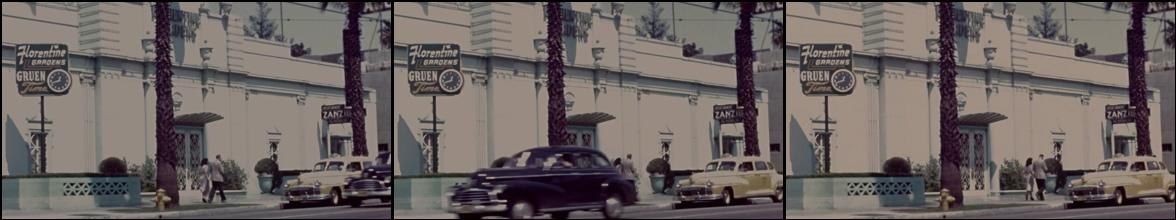


Chapter 5: frames 24 to 197, scenes 5 to 6, time 23089 to 198031 =======


Chapter Text: The topic discusses the disappearance of individuals on a specific stretch of road above El Matador. The conversation shifts to discussing the background of the individuals who disappeared, including their professions and personal histories. The topic changes to the possibility of suicide, but it is dismissed due to the lack of bodies and the presence of a witness. The conversation focuses on the witness's account of strange events, including a man on a rock, sudden dark weather, and the appearance of a mysterious woman.


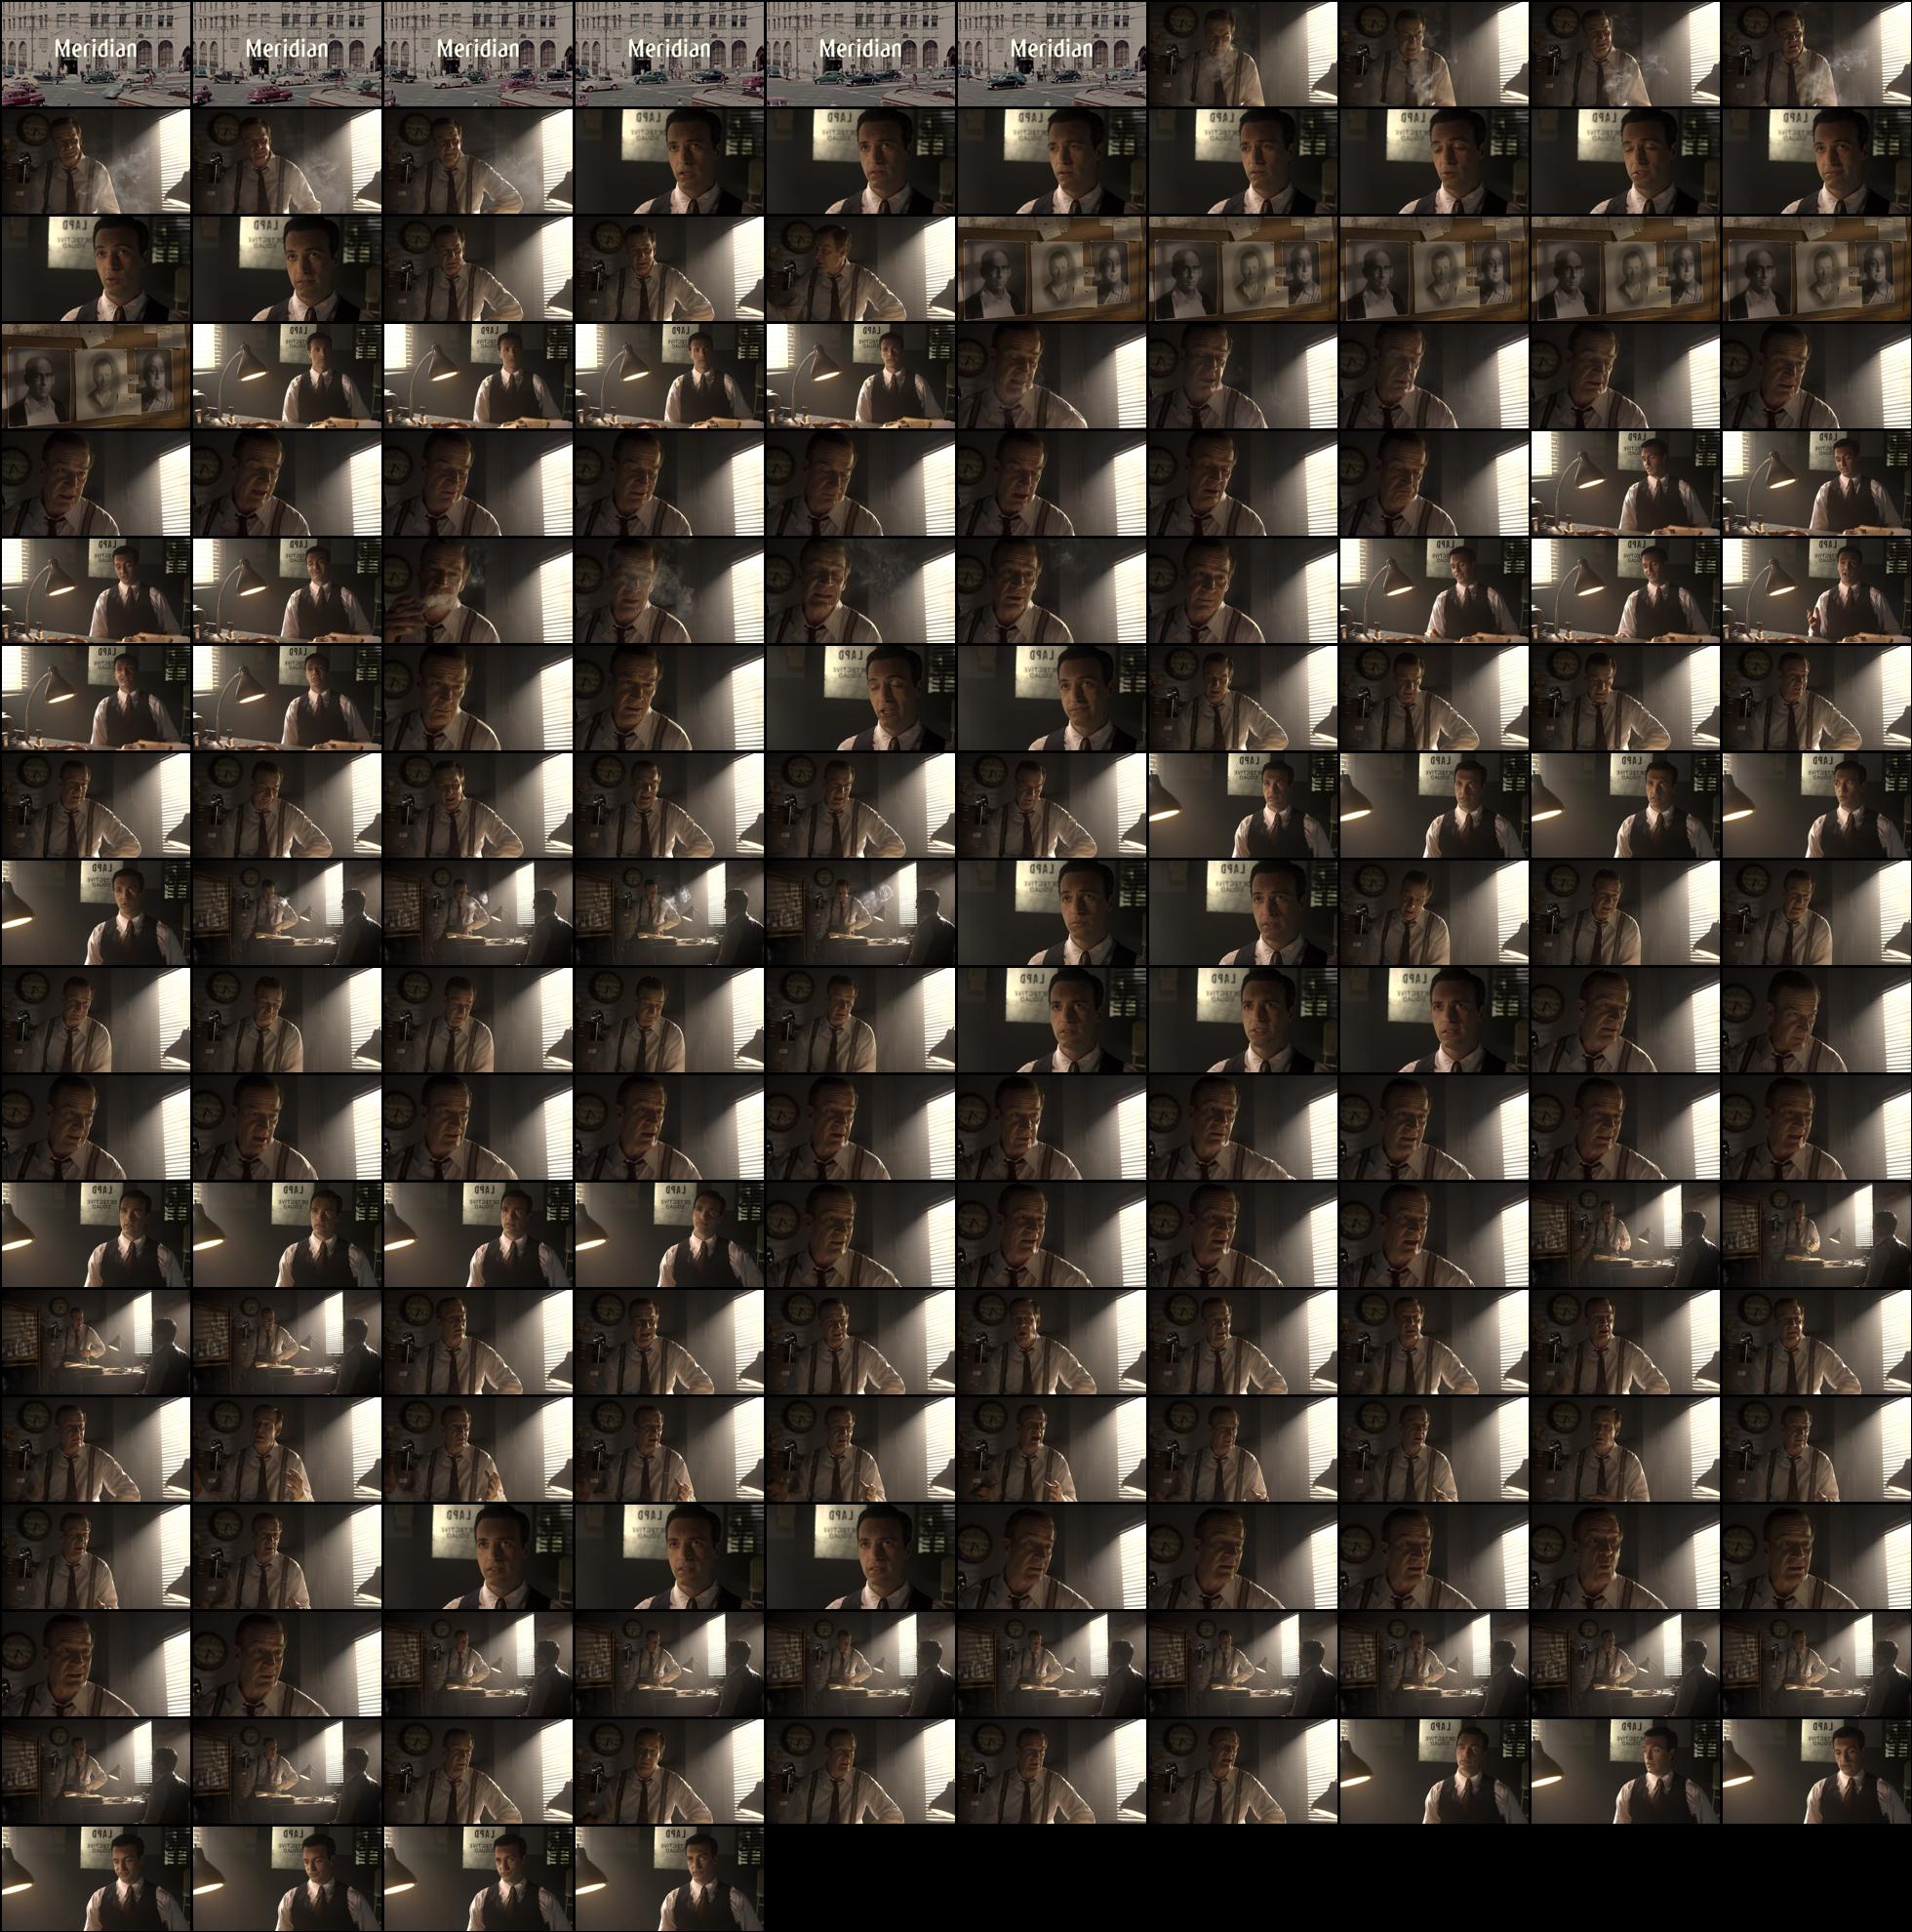


Chapter 6: frames 198 to 271, scenes 7 to 8, time 198064 to 272072 =======


Chapter Text: The topic shifts to the need to investigate further and find the woman described by the witness. The conversation reiterates the witness's account of the man disappearing and the woman appearing, emphasizing the strange and unbelievable nature of the events.


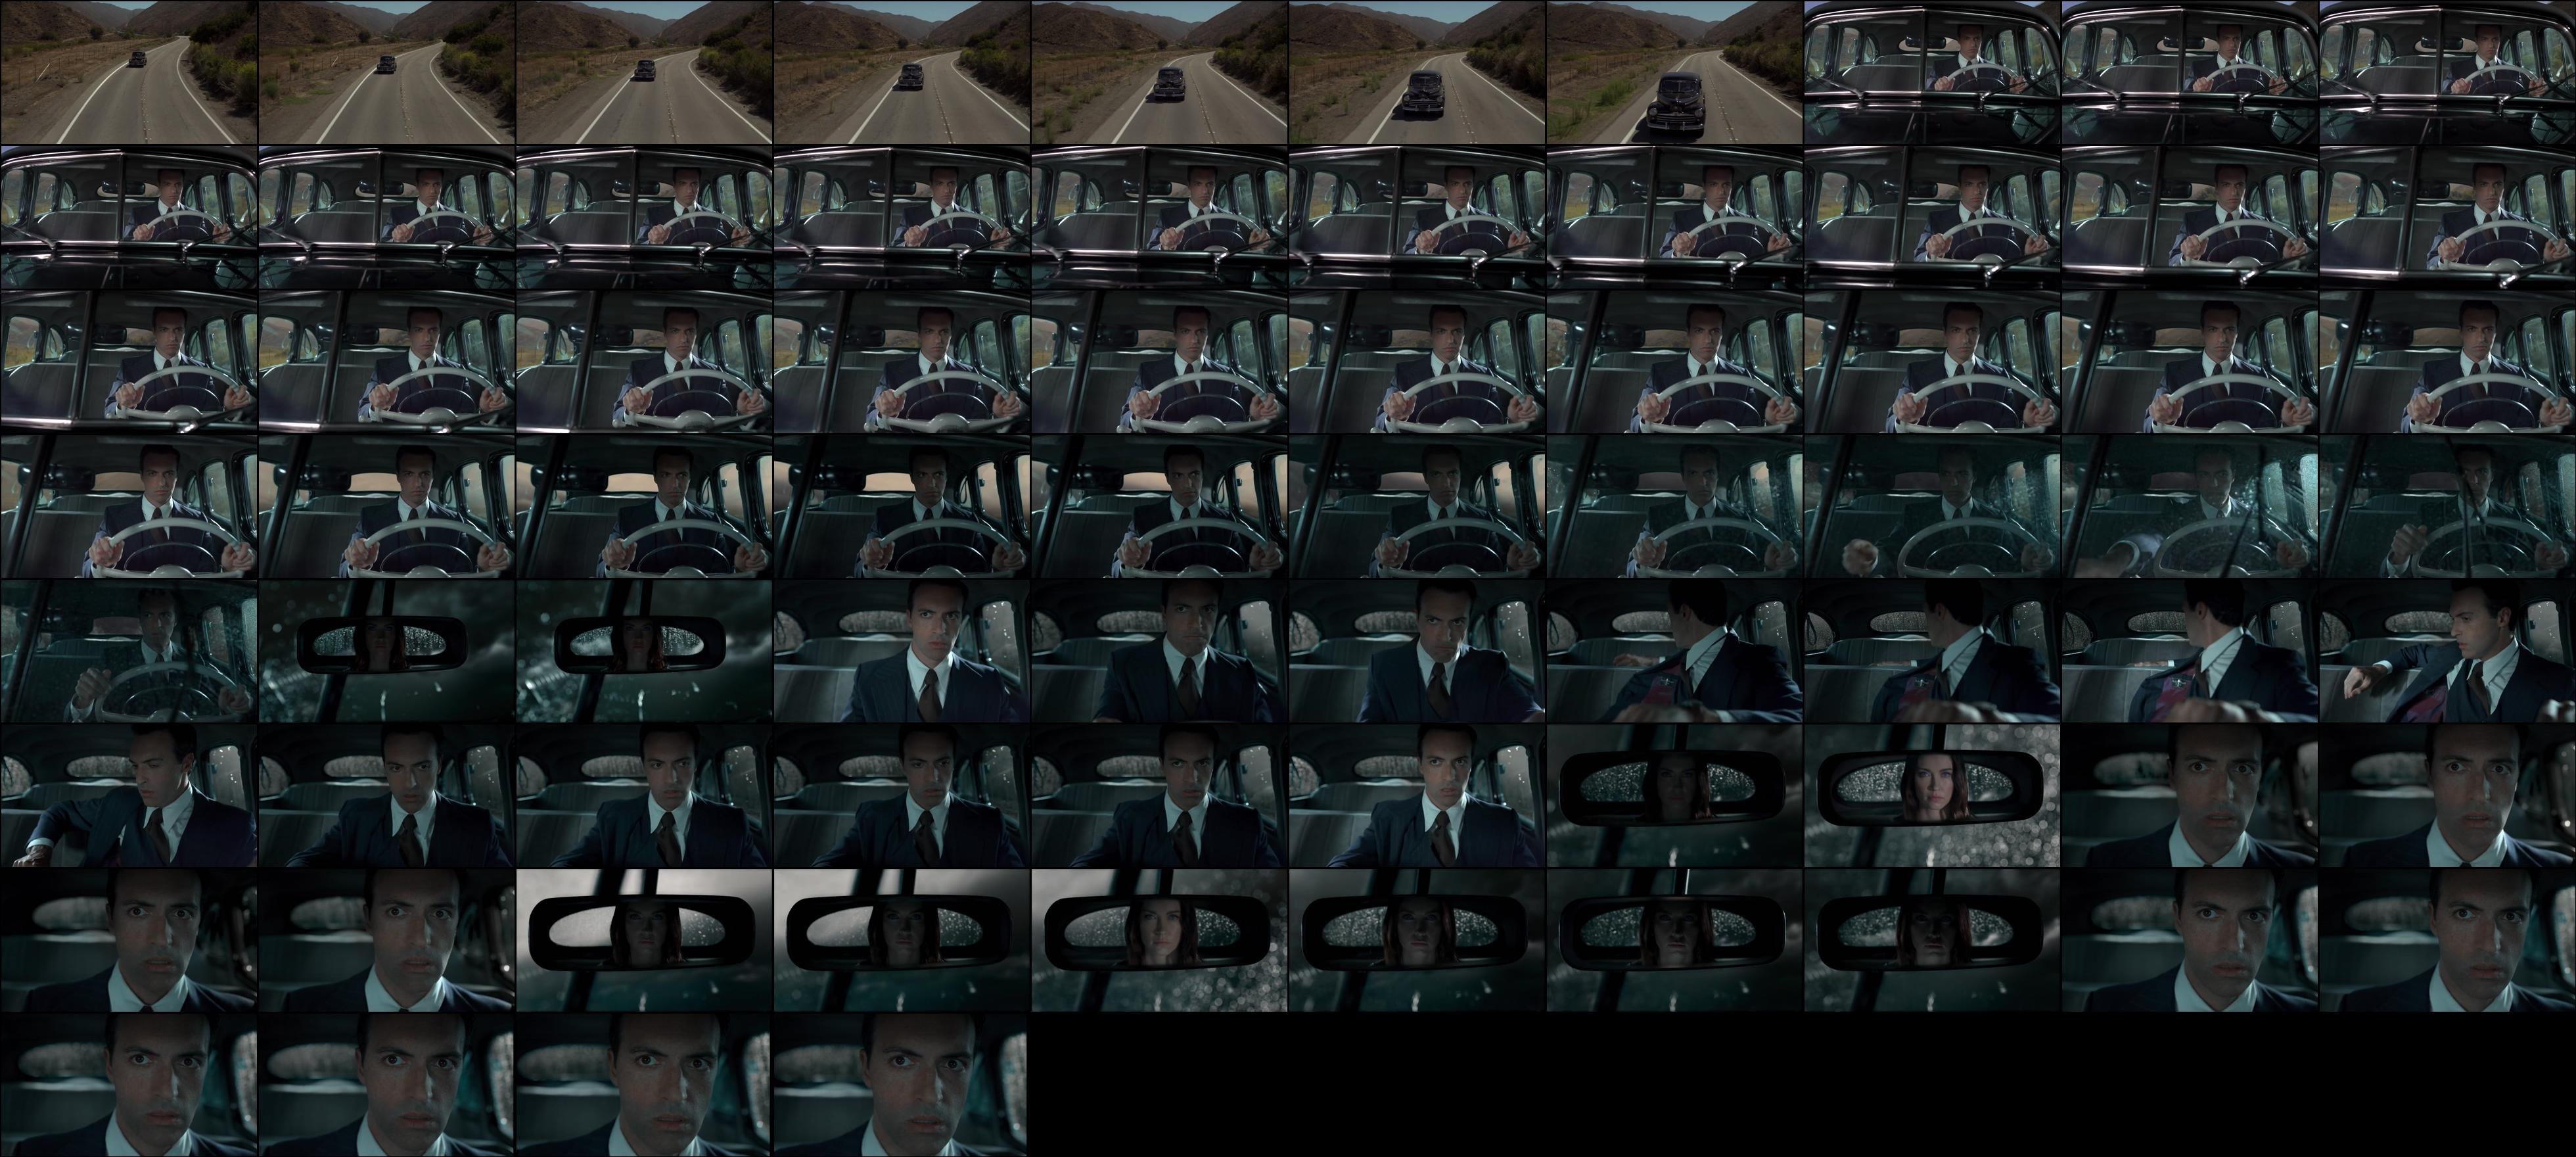


Chapter 7: frames 272 to 336, scenes 9 to 10, time 272105 to 336469 =======


Chapter Text: The topic changes to Captain Foster's arrival at the El Matador location and the absence of Detective Sullivan.


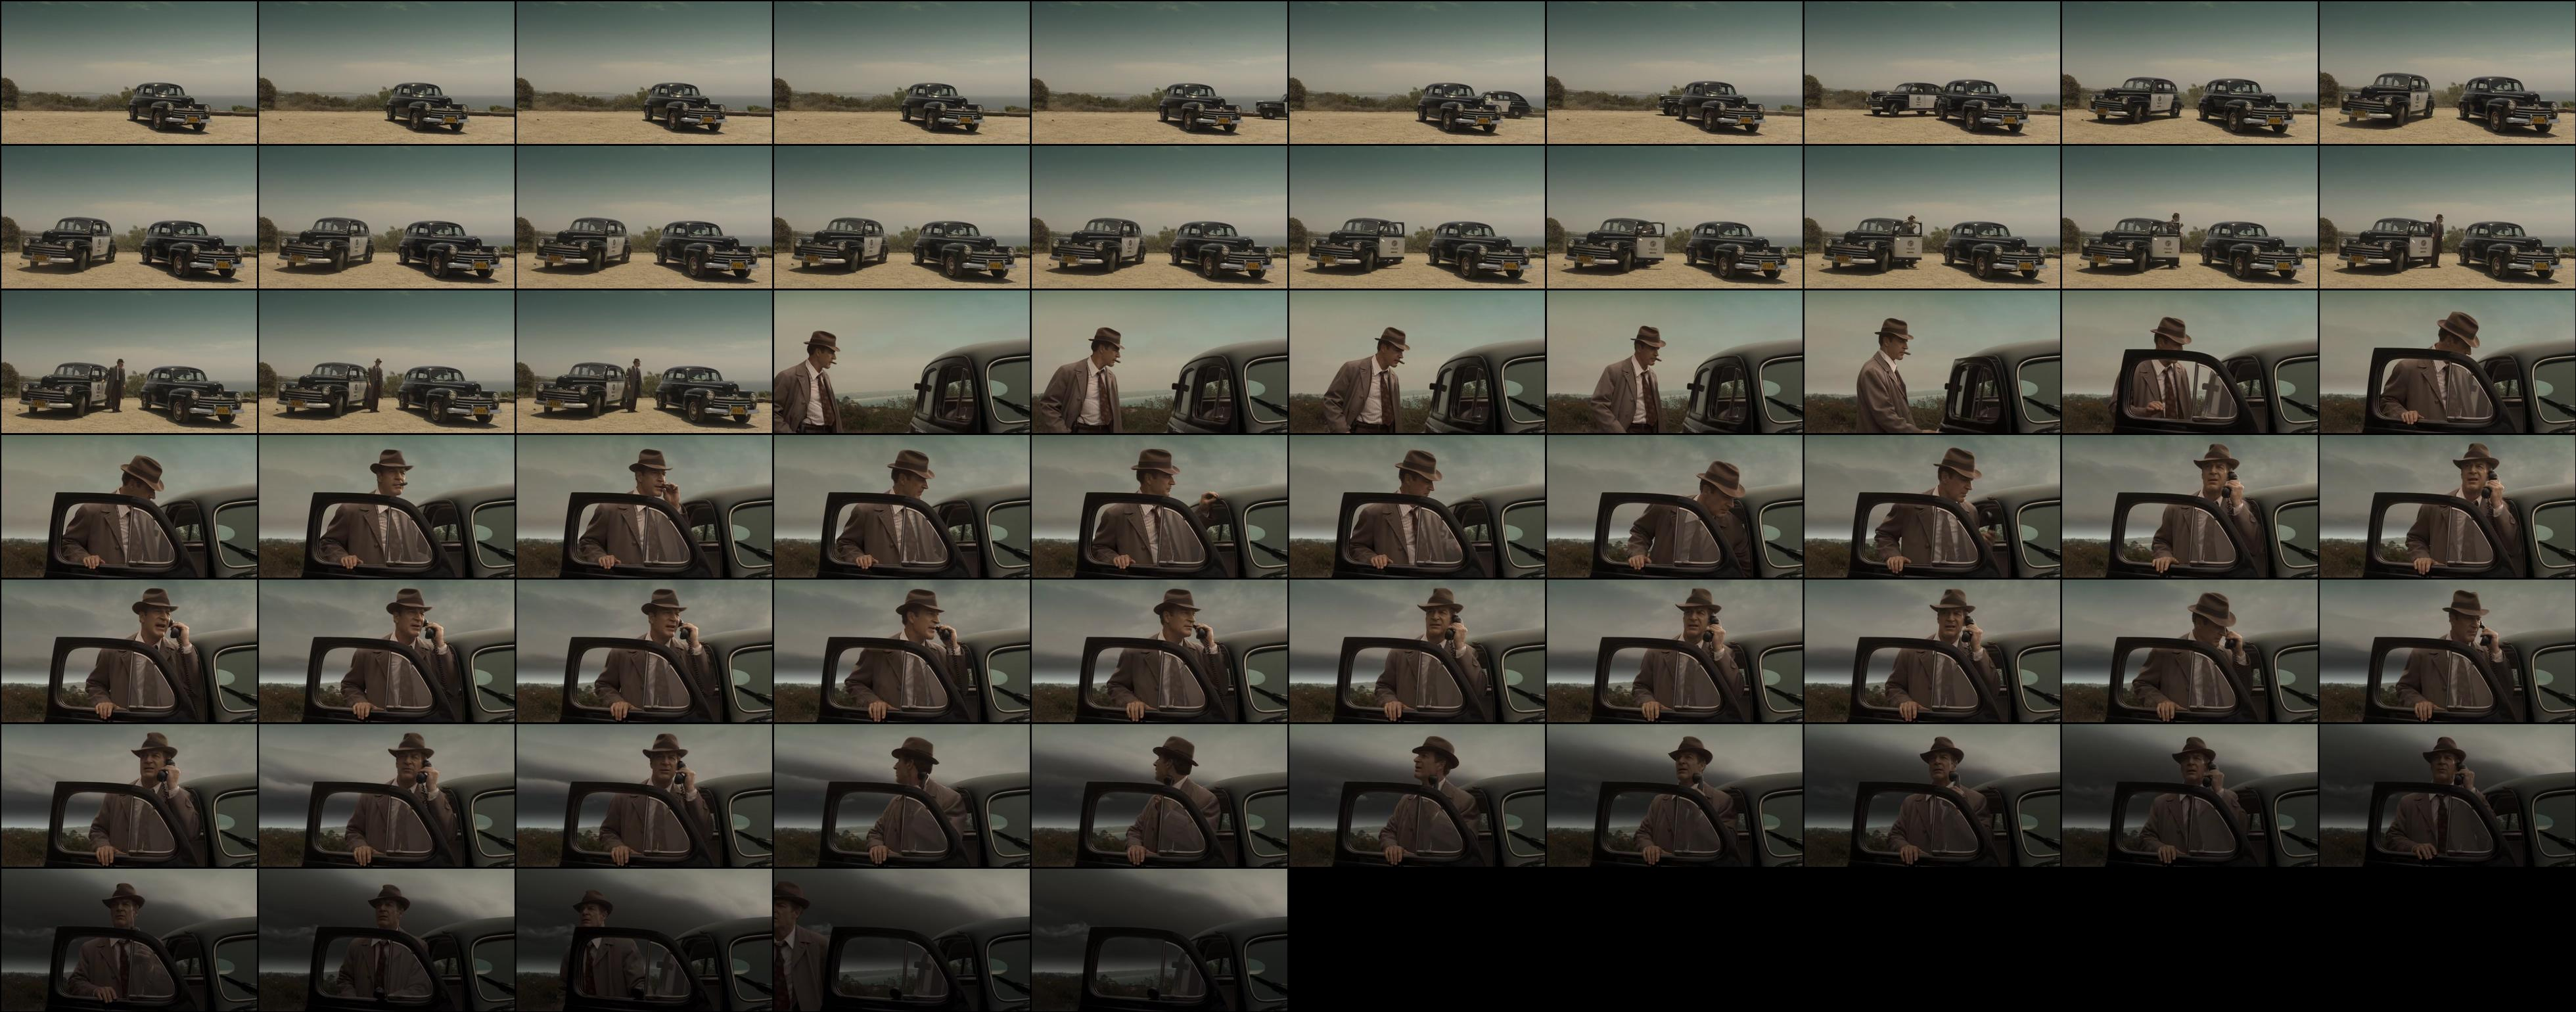


Chapter 8: frames 337 to 437, scenes 11 to 11, time 336503 to 437871 =======


Chapter Text: Captain Foster communicates with dispatch and prepares to investigate the area before any additional personnel arrive.


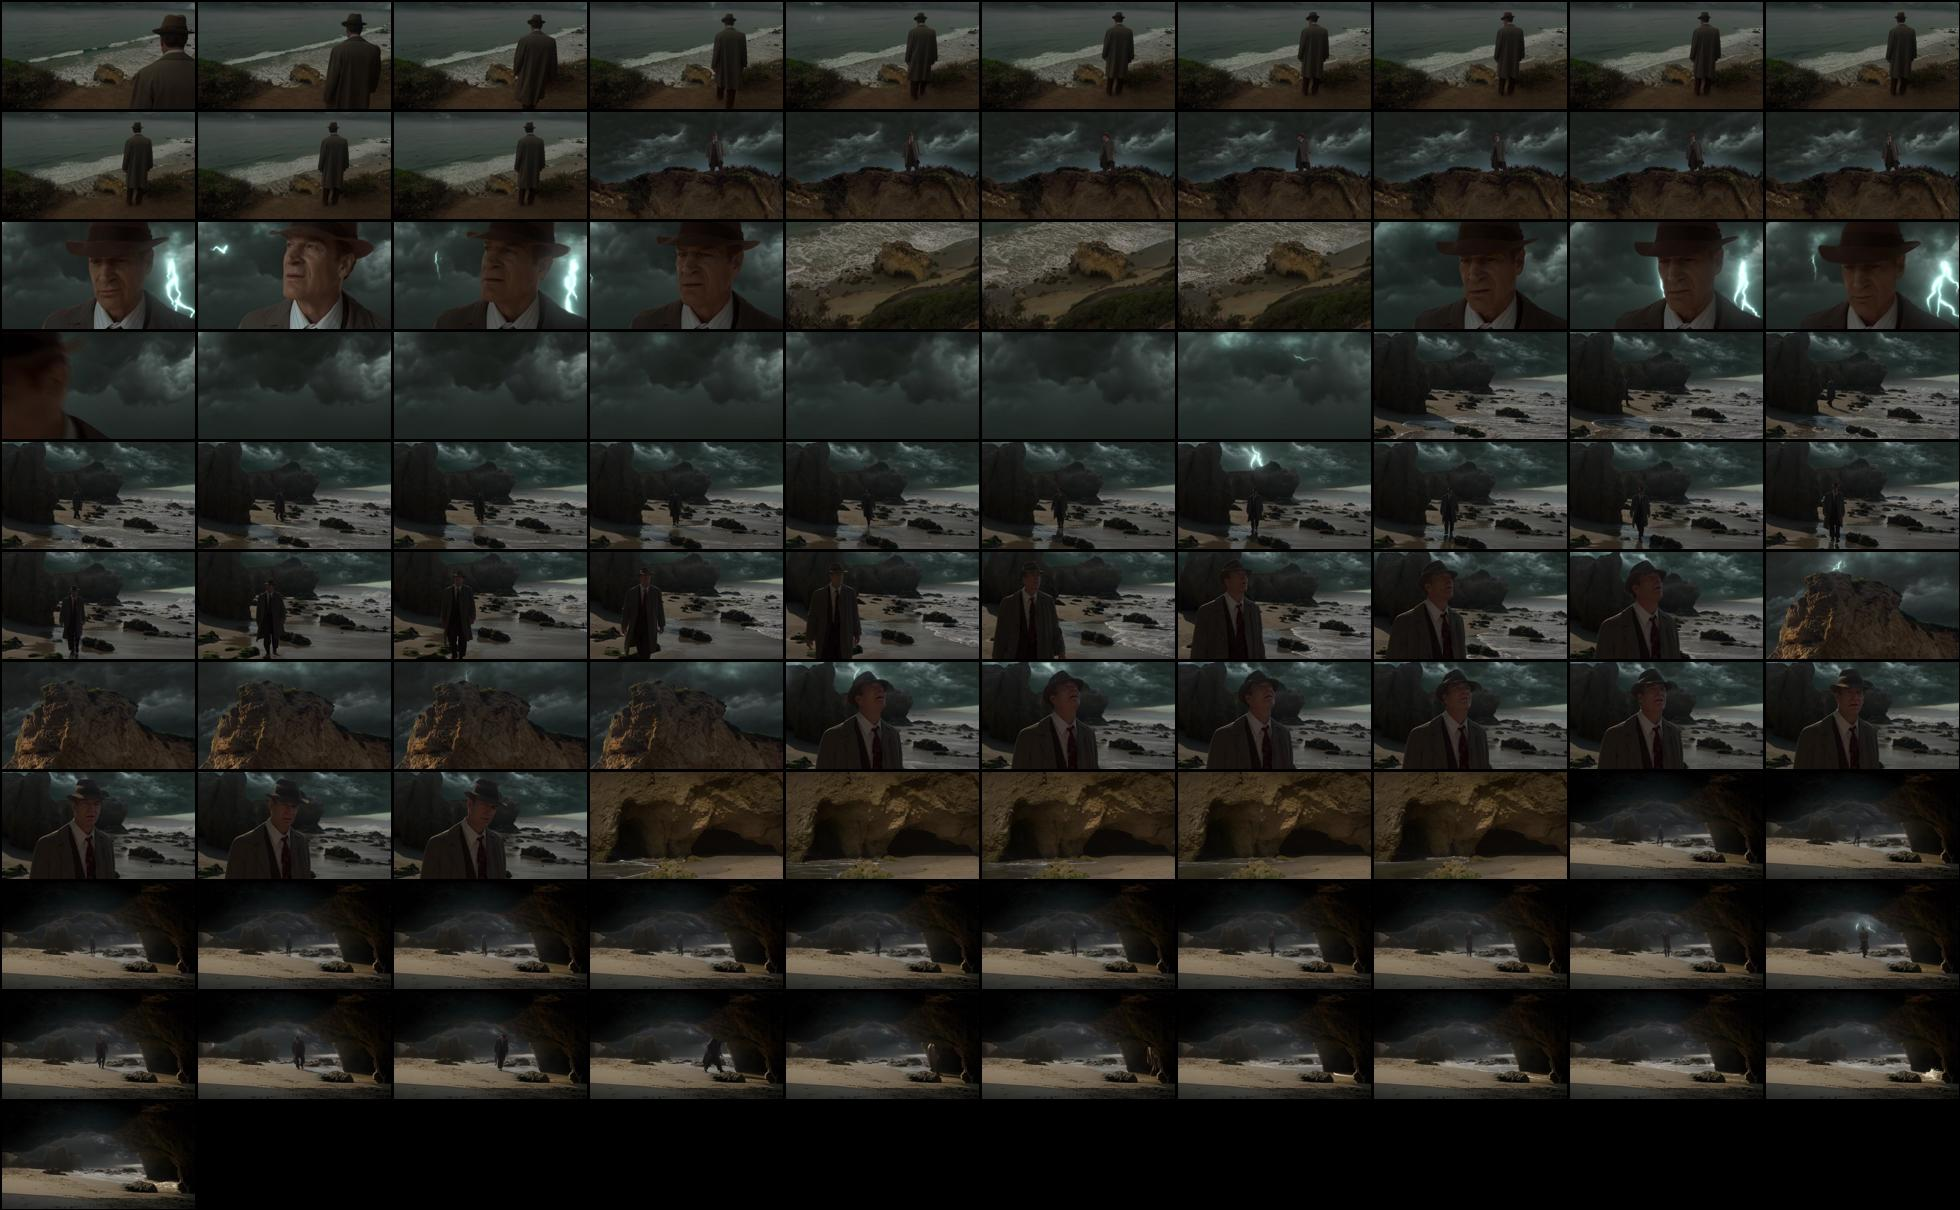


Chapter 9: frames 438 to 570, scenes 12 to 12, time 437904 to 570670 =======


Chapter Text: The final topic involves a confrontation where LAPD officers demand someone to put their hands in the air.


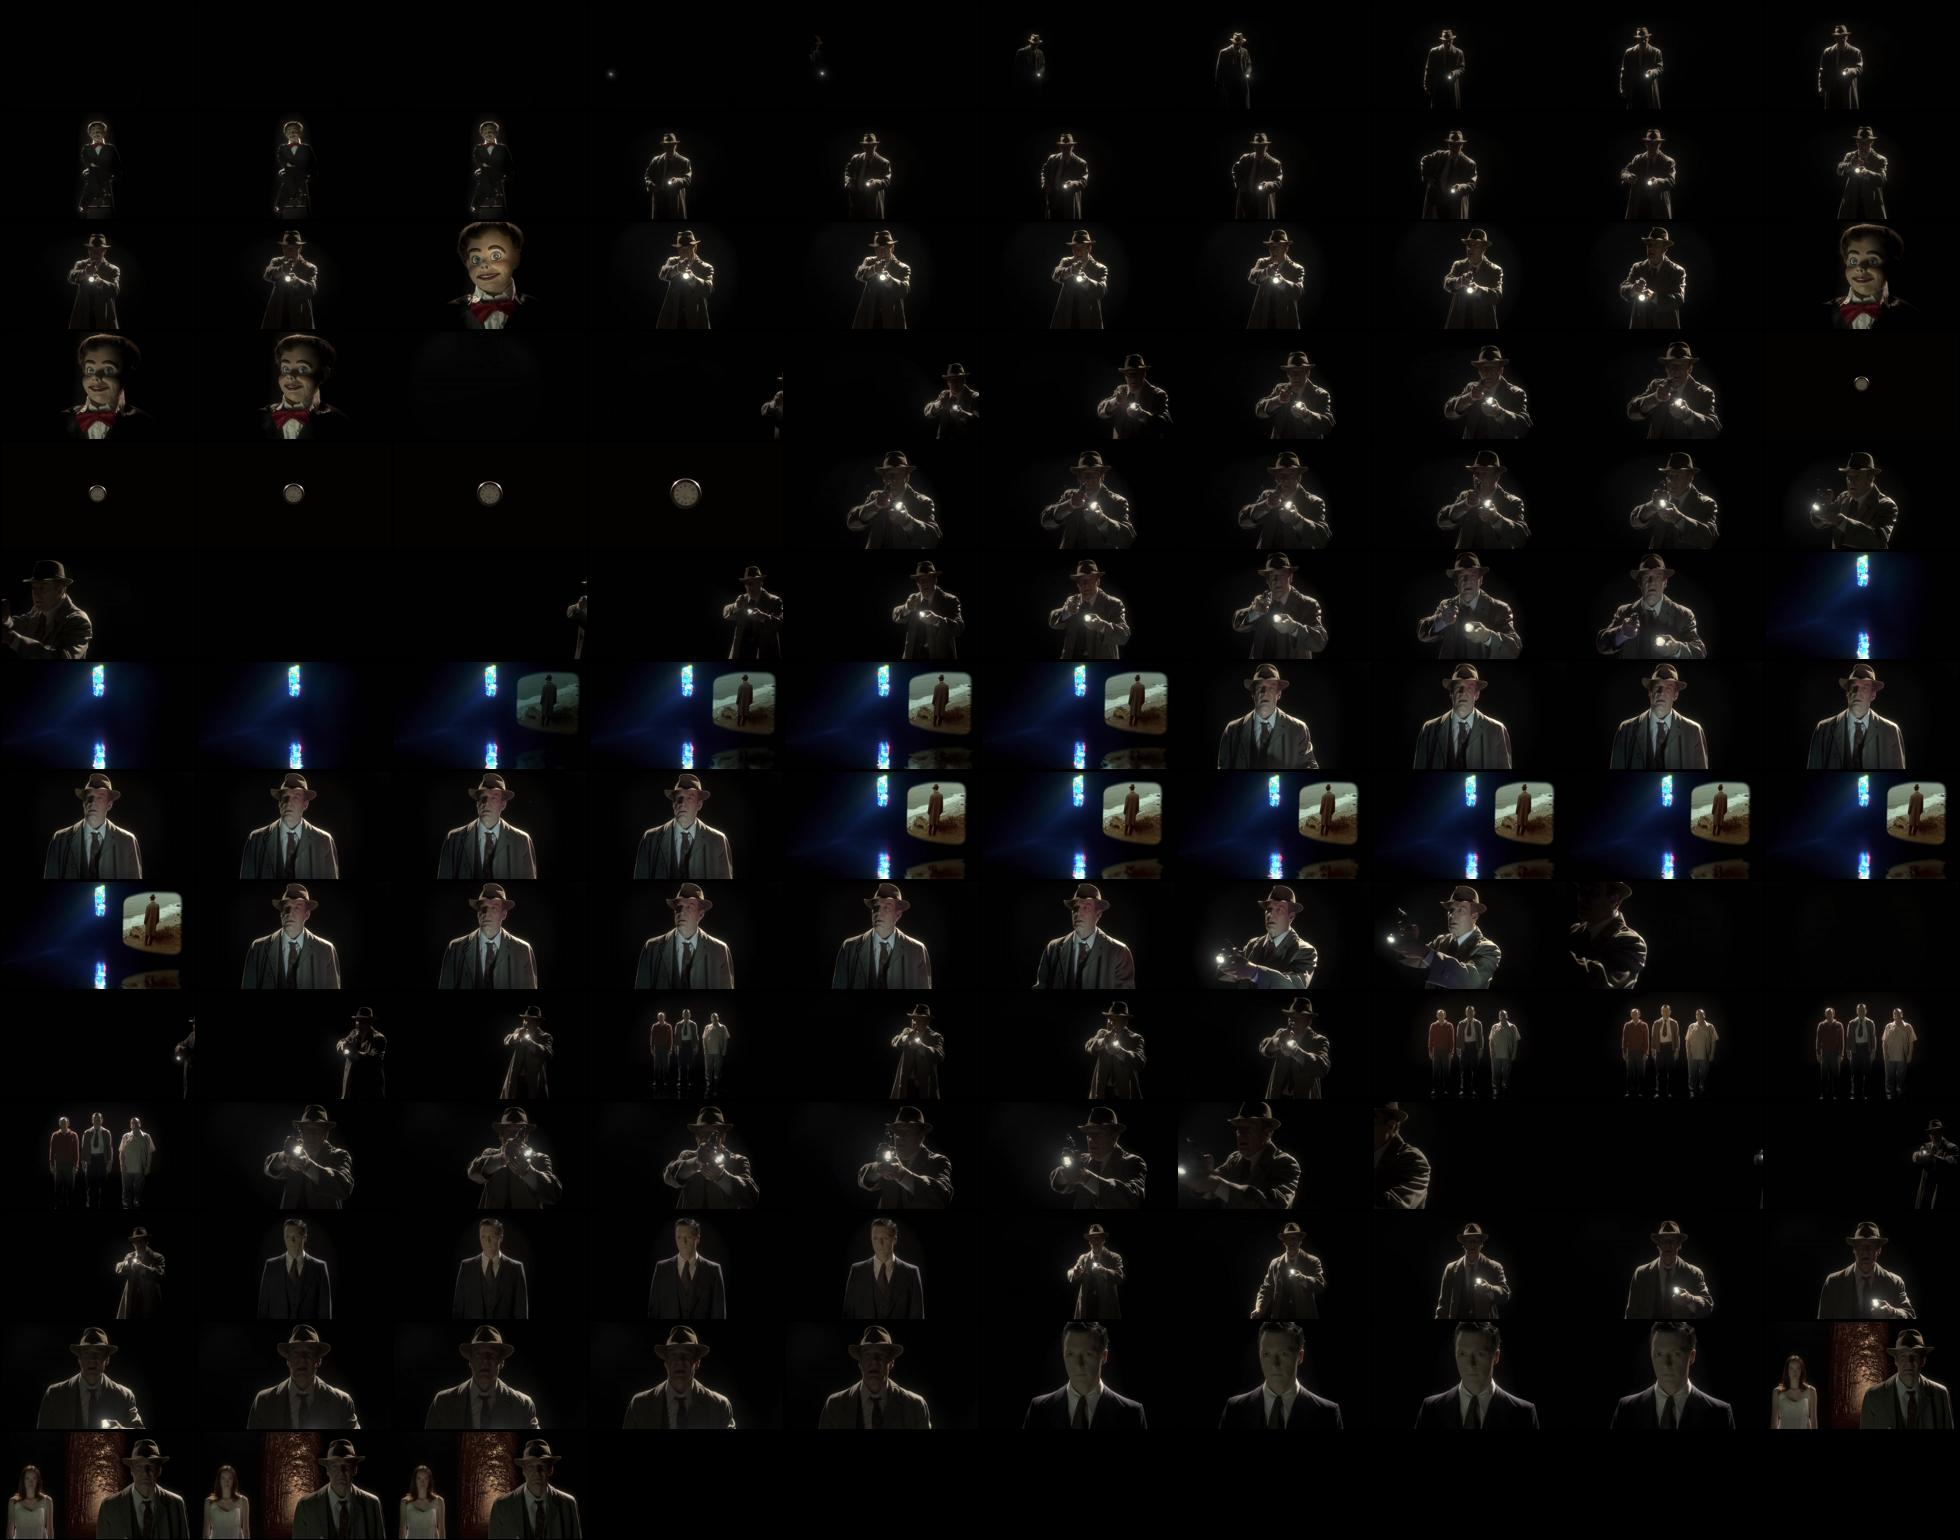


Chapter 10: frames 571 to 578, scenes 13 to 13, time 570704 to 578645 =======


Chapter Text (conversation topic): None


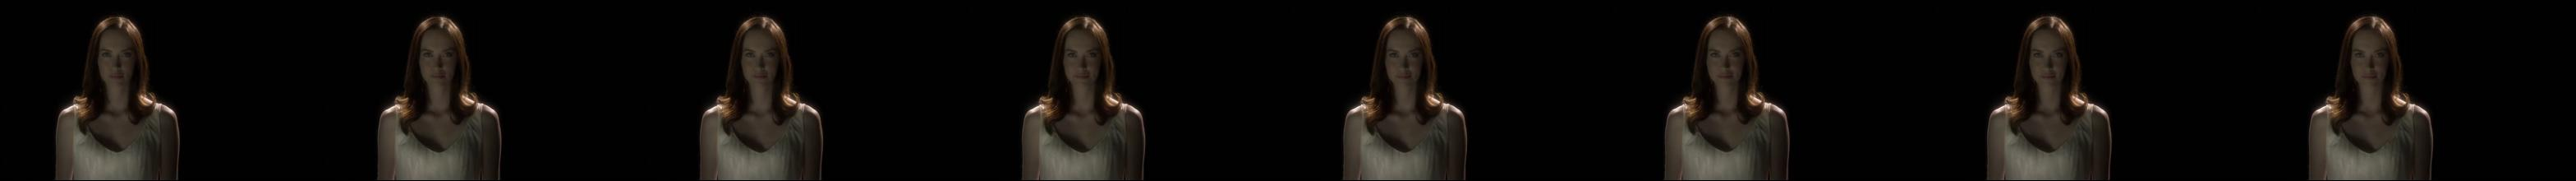


Chapter 11: frames 579 to 718, scenes 14 to 14, time 578678 to 718885 =======


Chapter Text (conversation topic): None


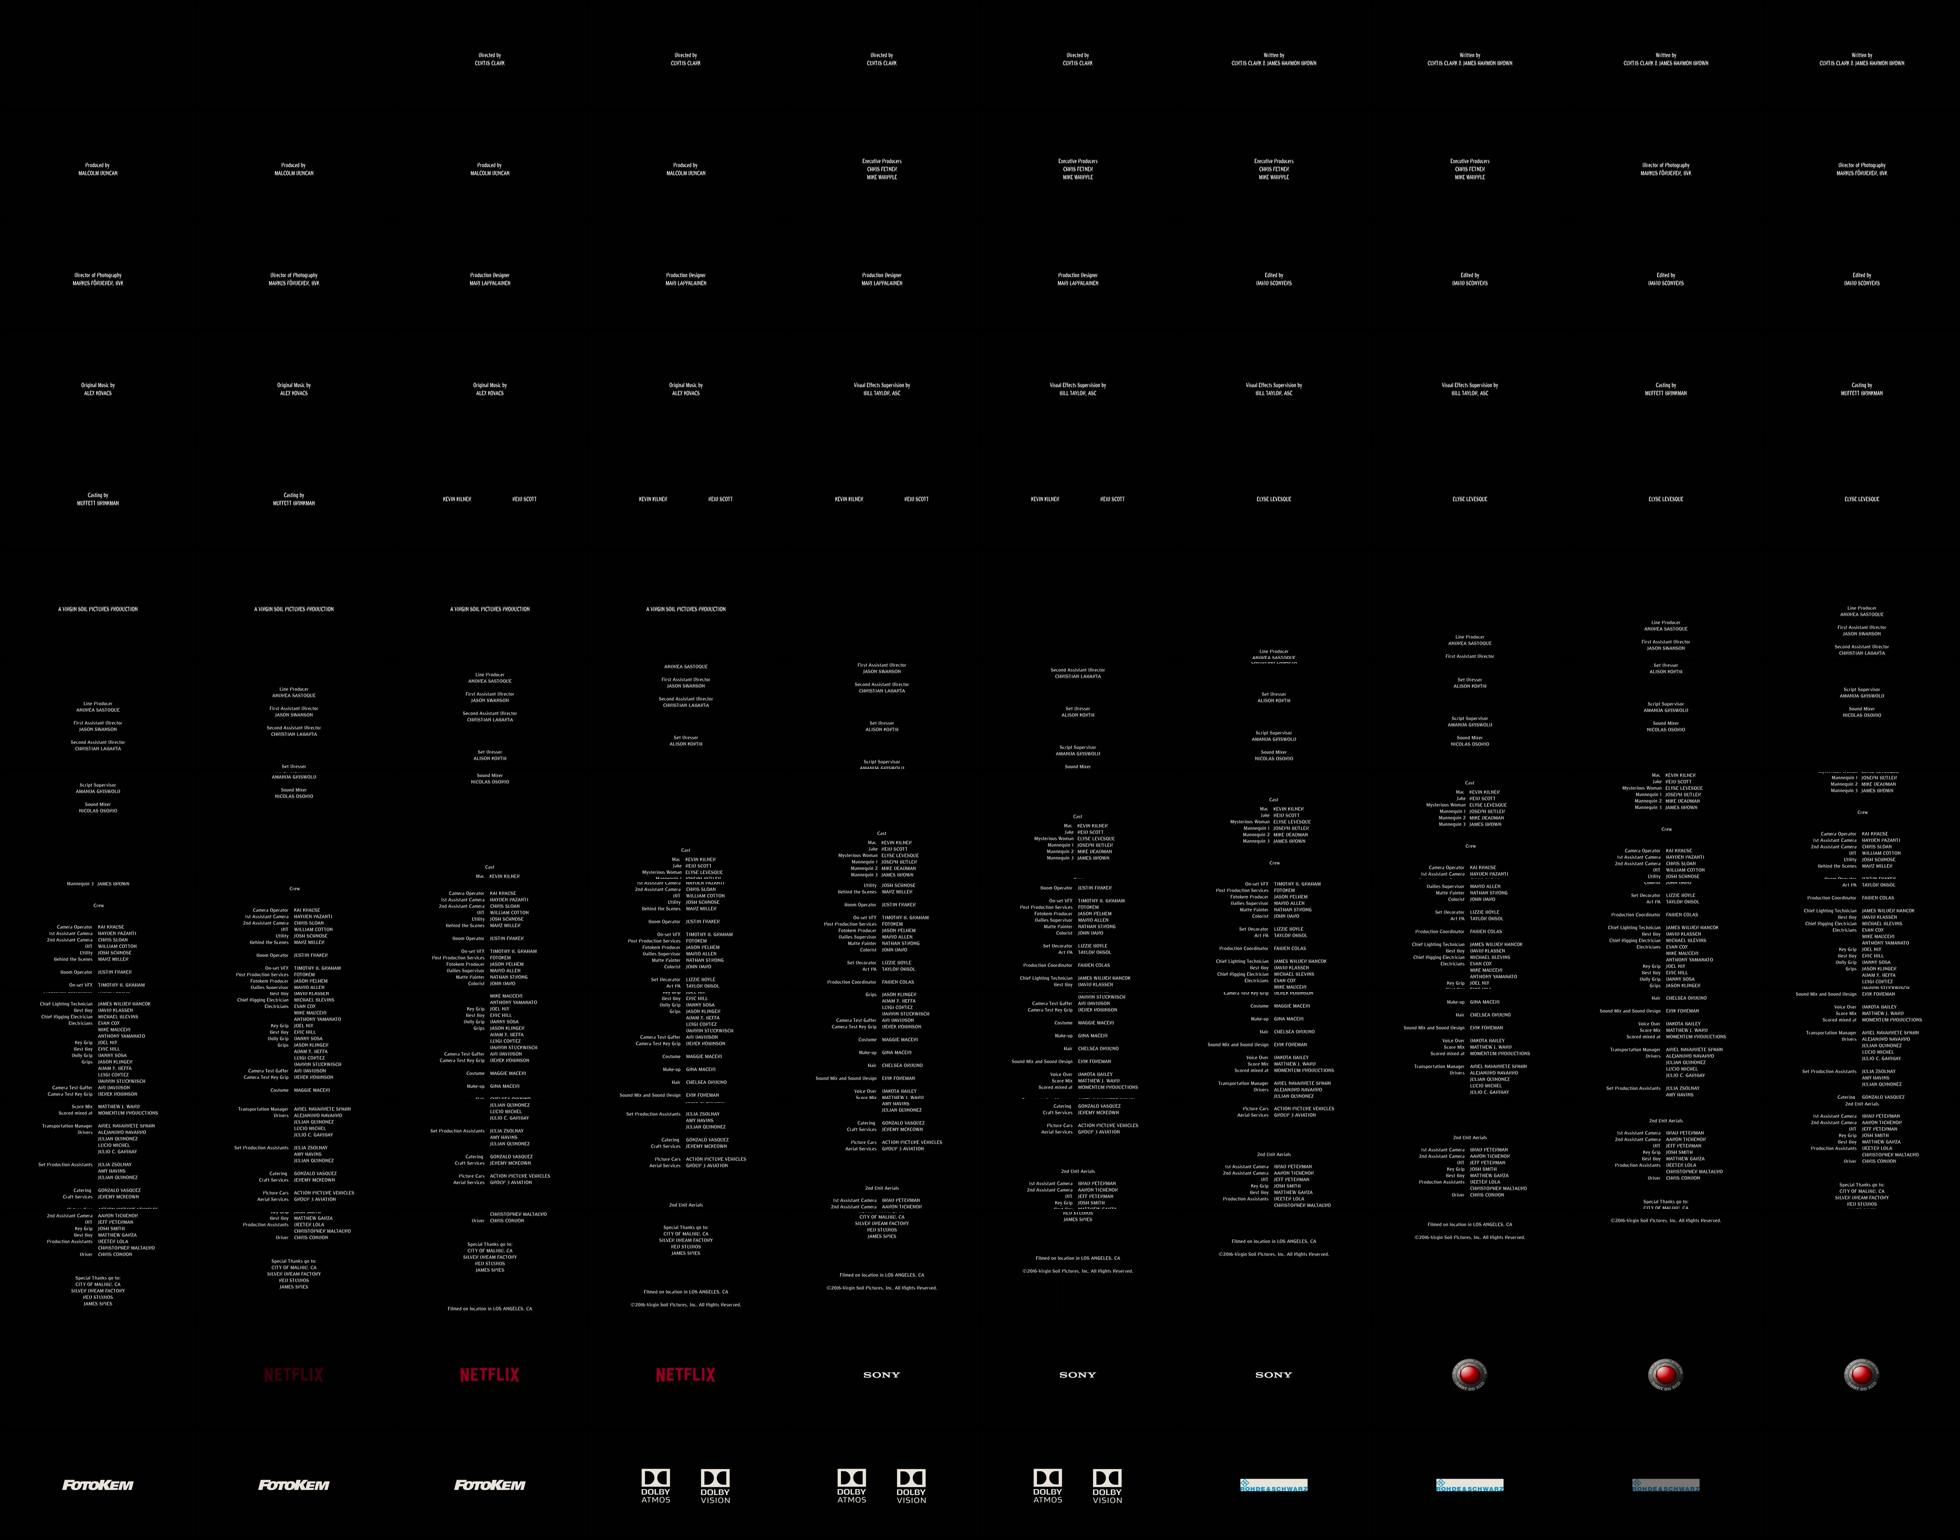

In [6]:
# visualize the chapters

STOP=10
for counter, b in enumerate(video["chapters"].chapters):
    print(f'\nChapter {counter}: frames {b["start_frame_id"] } to {b["end_frame_id"] }, scenes { b["scene_ids"][0] } to { b["scene_ids"][-1] }, time { b["start_ms"]} to { b["end_ms"] } =======\n')
    if len(b["text"]) > 0: 
        print(f'\nChapter Text: { b["text"] }')
    else:
        print(f'\nChapter Text (conversation topic): None')

    video['frames'].display_frames(start=b['start_frame_id'], end=b['end_frame_id']+1)

    # ALTERNATIVE: view the composite images that will be used in prompts
    #for image_file in b['composite_images']:
    #    display(DisplayImage(filename=image_file['file'], height=100))
    #if counter == STOP:
    #    break

# Generate chapter level contextual information 

The last step is to send both the visually and audio-aligned data to Claude 3 Sonnet to generate contextual information for each topic. This approach that takes advantage of the multimodal capabilities of the Claude 3 family of models. From our testing, these models have demonstrated the ability to capture minute details from large images and follow image sequences when provided with appropriate instructions.

To prepare the input for Claude3 Sonnet, we first assemble video frames associated with each topic and create a composite image grid. Through our experimentation, we have found that the optimum image grid ratio is 7 rows by 4 columns, which will assemble a 1568 x 1540 pixel image that fits under Claude's 5 MB image file size limit while still preserving enough detail in each individual frame tile. Furthermore, you can also assemble multiple images if needed.

Subsequently, the composite images, the transcription, the IAB Content taxonomy definitions, and GARM taxonomy definitions are fed into the prompt to generate descriptions, sentiment, IAB taxonomy, GARM taxonomy, and other relevant information in a single query to the Claude3 Haiku model. Not only that, but we can adapt this approach to any taxonomy or custom labeling use cases without the need to train a model each time. This is where the true power of this approach lies. The final output can be presented to a human reviewer for final confirmation if needed. Here is an example of a composite image grid and the corresponding contextual output for a specific topic.

![Contextualized chapters](./static/images/02-chapter-contextualization.png)

## Download the IAB Content Taxonomy definition

The IAB (Interactive Advertising Bureau) Taxonomy is a standardized classification system for digital advertising content and audiences. It provides a hierarchical structure to categorize digital content, making it easier for advertisers and publishers to organize, target, and measure digital advertising.

You will instruct Anthropic Claude to use this taxonomy to classify the chapters to help identify the kinds of advertisements that might fit between different chapters.

In [7]:
iab_file = 'iab_content_taxonomy_v3.json'
url = f"https://dx2y1cac29mt3.cloudfront.net/iab/{iab_file}"

!curl {url} -o {iab_file}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 98444  100 98444    0     0   239k      0 --:--:-- --:--:-- --:--:--  239k


In [8]:
def load_iab_taxonomy(file):
    """
    Loads IAB taxonomy definitions from a JSON file.
    Args:
        file: Path to the IAB taxonomy JSON file
    Returns:
        Dictionary containing IAB taxonomy definitions
    """
    with open(file) as f:
        iab_taxonomies = json.load(f)
    return iab_taxonomies

In [9]:
iab_taxonomy = load_iab_taxonomy(iab_file)
display(JSON(iab_taxonomy))

<IPython.core.display.JSON object>

## Construct a prompt to generate contextual metadata for each chapter segment

This example uses the [Anthropic Claude Messages API (aka Conversations API)](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-anthropic-claude-messages.html) with Amazon Bedrock for this prompt that simulates a multi-turn conversation with the Foundation model. 

First, let's create some helper functions to create text for parts of the prompts.

In [10]:
# Constructors for parts of prompt messages

def make_iab_taxonomoies(iab_list):
    iab=""
    for item in iab_list:
        iab += f"- {item['name']}\n"
        
    iab += "- None\n"

    return iab

def make_image_message(composite_images):
    """
    Converts a list of image files into a formatted message with base64-encoded images.
    Args:
        composite_images: List of dicts containing image file paths
    Returns:
        Dict with 'role' and 'content' containing:
        - Text description of number of images
        - List of base64-encoded images with metadata
    """
    # adding the composite image sequences
    image_contents = [{
        'text': 'Here are {0} images containing frame sequence that describes a scene.'.format(len(composite_images))
    }]

    for image in composite_images:
        with open(image['file'], "rb") as image_file:
            image_data = image_file.read()
            image_contents.append({
                "image": {
                    "format": "jpeg",
                    "source": {
                        "bytes": image_data,
                    },
                }
            })

    return {
        'role': 'user',
        'content': image_contents
    }

def make_output_example():
    """
    Creates a template message for AI model output formatting.
    Returns:
        Dict with 'role' and 'content' keys containing example JSON structure for:
        - Scene description
        - Sentiment analysis
        - IAB and GARM taxonomies
        - Brand/logo detection
        - Relevant tags
    Note:
        Used as part of the prompt to ensure consistent response formatting
    """
    example = {
        'description': {
            'text': 'The scene describes...',
            'score': 98
        },
        'sentiment': {
            'text': 'Positive',
            'score': 90
        },
        'iab_taxonomy': {
            'text': 'Station Wagon',
            'score': 80
        },
        'garm_taxonomy': {
            'text': 'Online piracy',
            'score': 90
        },
        'brands_and_logos': [
            {
                'text': 'Amazon',
                'score': 95
            },
            {
                'text': 'Nike',
                'score': 85
            }
        ],
        'relevant_tags': [
            {
                'text': 'auto racing',
                'score': 95
            }
        ]            
    }
    
    return {
        'role': 'user',
        'content': [{'text':'Return JSON format. An example of the output:\n{0}\n'.format(json.dumps(example))}]
    }

This next block of code constructs the prompt using the helper functions and calls Amazon Bedrock to make the inference.

In [11]:
def get_chapter_description(images, text, iab_definitions):
    """
    Generates chapter descriptions using image analysis, text, and IAB classifications.
    Args:
        images: List of image analysis results (max 19 images)
        text: Transcribed conversation/text (optional)
        iab_definitions: IAB taxonomy definitions with tier1 classifications
    Returns:
        Dict containing chapter description, IAB classifications, and sentiment analysis
    Note:
        - Uses Claude model for analysis
        - Requires make_iab_taxonomies(), make_output_example(), make_image_message()
        - Implements retry logic for failed inference calls
    """

      
    system = [{'text':'''You are a media operation engineer. Your job is to review a clip from a video 
    content presented in a sequence of consecutive images. Each image
    contains a sequence of frames presented in a 4x7 grid reading from left to
    right and then from top to bottom. Interpret the frames as the time 
    progression of a video clip.  Don't refer to specific frames, instead, think
    about what is happening over time in the scene.  You may also optionally be given the
    conversation of the scene you can use to understand the context of
    the scene. 

    You are asked to provide the following information: a detailed 
    description to describe the scene using the visual and audio, identify the most relevant IAB taxonomy, 
    GARM, sentiment, and brands and logos that 
    may appear in the scene, and five most relevant tags from the scene.
    
    It is important to return the results in JSON format and also includes a
    confidence score from 0 to 100. Skip any explanation.
    '''}]

    other_information = []
    other_information.append(
        {
            "text": f'''
                    Here is a list of IAB Taxonomies. Only answer 
                    the IAB taxonomy from this list.
                    
                    **IAB taxonomy:**
                    { json.dumps(make_iab_taxonomoies(iab_definitions['tier1'])) }

                    '''
        })
    
    other_information.append(
        {
            "text": f'''
                    Here is a list of GARM Taxonomies in <garm> tag. Only answer
                    the GARM taxonomy from this list.
                    
                    **GARM taxonomy:**
                    - Adult & Explicit Sexual Content
                    - Arms & Ammunition
                    - Crime & Harmful acts to individuals and Society, Human Right Violations
                    - Death, Injury or Military Conflict
                    - Online piracy
                    - Hate speech & acts of aggression
                    - Obscenity and Profanity, including language, gestures, and explicitly gory, graphic or repulsive content intended to shock and disgust
                    - Illegal Drugs, Tobacco, ecigarettes, Vaping, or Alcohol
                    - Spam or Harmful Content
                    - Terrorism
                    - Debated Sensitive Social Issue
                    - None
                    
                    '''
        })

    other_information.append(
        {
            "text": f'''
                Here is a list of Sentiments in <sentiment> tag. Only answer the
                sentiment from this list:

                **sentiment:**
                - Positive
                - Neutral
                - Negative
                - None

                '''
        })

    output_format_message = make_output_example()

    messages = []
 
    # adding sequences of composite images to the prompt.  Limit is 20.
    message_images = make_image_message(images[:19])
    messages.append(message_images)

    # adding the conversation to the prompt
    messages.append({
        'role': 'assistant',
        'content': [{'text':'Got the images. Do you have the conversation of the scene?'}]
    })

    message_conversation = {
        'role': 'user',
        'content': [{'text':'No conversation.'}]
    }
    if text:
        message_conversation['content'][0]['text'] = f'''
            Here is the conversation of the scene.
            
            **conversation:**
            { text }
            
            '''

    messages.append(message_conversation)

    # other information
    messages.append({
        'role': 'assistant',
        'content': [{'text':'OK. Do you have other information to provdie?'}]
    })

    messages.append({
        'role': 'user',
        'content': other_information
    })

    # output format
    messages.append({
        'role': 'assistant',
        'content': [{'text':'OK. What output format?'}]
    })
    messages.append(output_format_message)

    # prefill '{'
    messages.append({
        'role': 'assistant',
        'content': [{'text':'{'}]
    })
    
    infParams = {"maxTokens": 4096, "topP": 0.7, "temperature": 0.1}

    additionalFields = {
        "inferenceConfig": {
             "topK": 20
        }
    }
    
    try:
        response = inference(system, 
                             messages, 
                             model_id,
                             infParams,
                             additionalFields)    
    except Exception as e:
        print(colored(f"ERR: inference: {str(e)}\n RETRY...", 'red'))
        response = inference(system, 
                             messages, 
                             model_id,
                             infParams,
                             additionalFields)

    return response

def inference(system, messages, model_id, infParams, additionalFields):

    bedrock_runtime_client = boto3.client(service_name='bedrock-runtime')

    model_response = bedrock_runtime_client.converse(
        modelId=model_id, 
        messages=messages, 
        system=system, 
        inferenceConfig=infParams,
        additionalModelRequestFields=additionalFields
    )

    response_body = model_response["output"]["message"]

    # patch the json string output with '{' and parse it
    response_content = response_body['content'][0]['text']
    if response_content[0] != '{':
        response_content = '{' + response_content

    try:
        response_content = json.loads(response_content)
    except Exception as e:
        print(colored("Malformed JSON response. Try to repair it...", 'red'))
        try:
            response_content = json_repair.loads(response_content, strict=False)
        except Exception as e:
            print(colored("Failed to repair the JSON response...", 'red'))
            print(colored(response_content, 'red'))
            raise e

    response_body['content'][0]['json'] = response_content
    response_body['usage'] = model_response["usage"]

    return response_body


def display_contextual_cost(usage, pricing=(0,0)):
    """
    Calculate and display the estimated cost of using the model based on input and output tokens.
    Args:
        usage (dict): A dictionary containing token usage information with keys:
            - input_tokens (int): Number of input tokens used
            - output_tokens (int): Number of output tokens generated
    Returns:
        dict: A dictionary containing cost calculation details:
            - input_per_1k (float): Cost per 1000 input tokens
            - output_per_1k (float): Cost per 1000 output tokens
            - input_tokens (int): Number of input tokens used
            - output_tokens (int): Number of output tokens generated
            - estimated_cost (float): Total estimated cost in USD
    """
    # us-east-1 pricing
    input_per_1k, output_per_1k = pricing

    if 'input_tokens' in usage:
        input_tokens = usage['input_tokens']
    else:
        input_tokens = usage['inputTokens']

    if 'input_tokens' in usage:
        output_tokens = usage['output_tokens']
    else:
        output_tokens = usage['outputTokens']

    contextual_cost = (
        input_per_1k * input_tokens +
        output_per_1k * output_tokens
    ) / 1000

    print('\n')
    print('========================================================================')
    print('Estimated cost:', colored(f"${round(contextual_cost, 4)}", 'green'), f"in us-east-1 region with {colored(input_tokens, 'green')} input tokens and {colored(output_tokens, 'green')} output tokens.")
    print('========================================================================')

    return {
        'input_per_1k': input_per_1k,
        'output_per_1k': output_per_1k,
        'input_tokens': input_tokens,
        'output_tokens': output_tokens,
        'estimated_cost': contextual_cost,
    }


## Execute the prompt against all the chapter segments

In [12]:
import lib.bedrock_converse_helper as brch

model_id = "us.amazon.nova-pro-v1:0"
PRICING = (0.0008, 0.0032)

# uncommon below to try this with Anthropic Claude Sonnet 3
# model_id = "us.anthropic.claude-3-sonnet-20240229-v1:0"
# PRICING = (0.003, 0.015)

In [16]:
total_usage

{'input_tokens': 83950, 'output_tokens': 3756}

==== Chapter #00: Contextual information ======


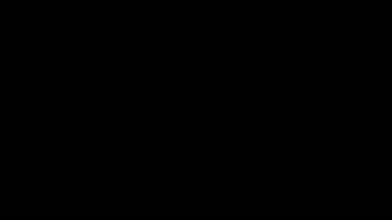

Description: The scene is completely black with no visible objects, actions, or subjects. There are no discernible elements or context to describe. (100%)
Sentiment: Neutral (100%)
Iab_taxonomy: None (100%)
Garm_taxonomy: None (100%)
Brands_and_logos: None
Relevant_tags: black screen, no content, void, empty, nothing


==== Chapter #01: Contextual information ======


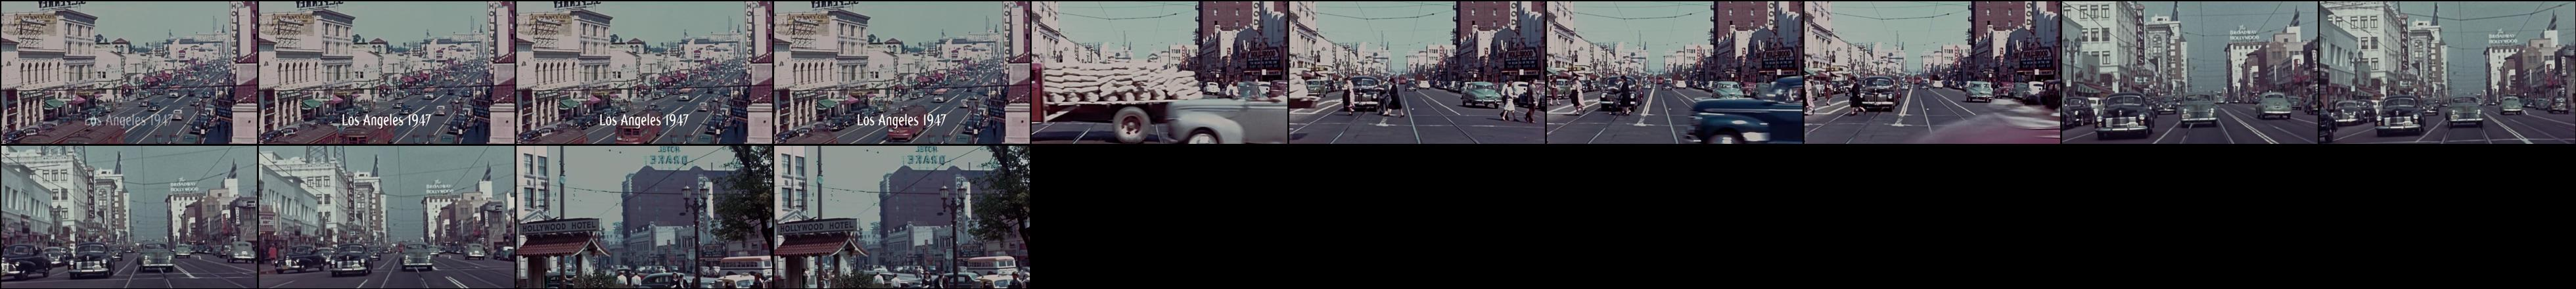

Description: The scene depicts various street views of Los Angeles in 1947, showing a bustling urban environment with vintage cars, trams, and pedestrians. The architecture and signage suggest a mid-20th-century setting, with notable landmarks and street names visible. The atmosphere is lively, with a mix of commercial and residential areas. (95%)
Sentiment: Neutral (85%)
Iab_taxonomy: Travel (90%)
Garm_taxonomy: None (100%)
Brands_and_logos: Hollywood, Warners
Relevant_tags: 1947, Los Angeles, vintage cars, urban environment, trams


==== Chapter #02: Contextual information ======


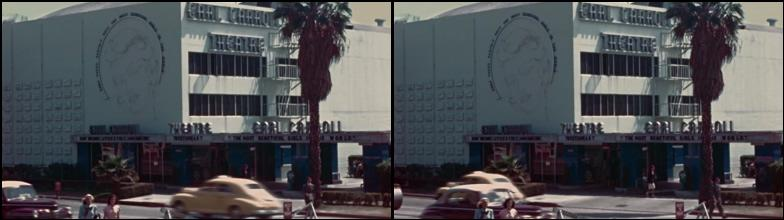

Description: The scene depicts a street view of a large, multi-story building with a prominent sign reading 'Earl Carroll Theatre'. The architecture is mid-century modern with a geometric pattern on the facade. There are palm trees in front of the building, suggesting a warm climate. Several vintage cars are visible on the street, including a yellow taxi and a dark-colored sedan. Pedestrians are walking on the sidewalk, and there is a sense of activity and movement in the scene. (95%)
Sentiment: Neutral (85%)
Iab_taxonomy: Attractions (80%)
Garm_taxonomy: None (90%)
Brands_and_logos: Earl Carroll Theatre
Relevant_tags: vintage cars, mid-century modern architecture, palm trees, pedestrians, theatre


==== Chapter #03: Contextual information ======


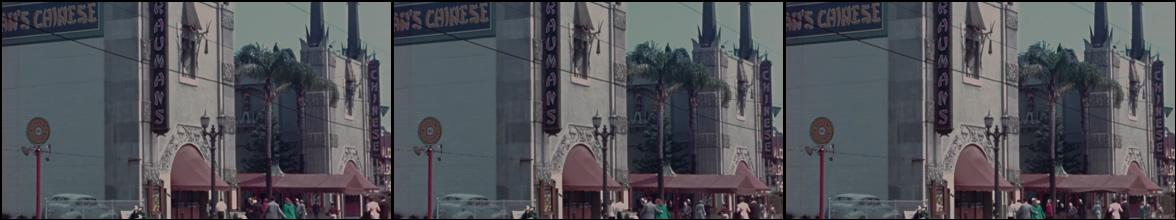

Description: The scene depicts a busy street with a large building in the background. The building has a prominent sign that reads "Kwan's Chinese" and "Kwan's" on the side. The street is lined with palm trees and streetlights. There are people walking on the sidewalk, and some are standing near the awnings of the building. The scene appears to be set in a city, possibly in a Chinatown area. (95%)
Sentiment: Neutral (90%)
Iab_taxonomy: Attractions (85%)
Garm_taxonomy: None (90%)
Brands_and_logos: None
Relevant_tags: cityscape, Chinese restaurant, palm trees, streetlights, sidewalk


==== Chapter #04: Contextual information ======


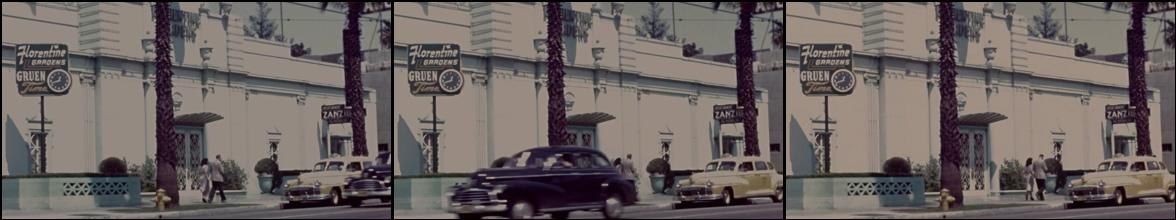

Description: The scene depicts a street view with a series of vintage cars parked along the side of the road. The cars are of different colors and models, suggesting a time period from the mid-20th century. The buildings in the background have a classic architectural style with signs that read 'Florentine Gardens' and 'GRUEN Time', indicating the presence of a theater or entertainment venue. There are also palm trees and other vegetation, suggesting a warm climate. The scene appears to be a snapshot of a bygone era, possibly from the 1940s or 1950s. (95%)
Sentiment: Neutral (90%)
Iab_taxonomy: Automotive (85%)
Garm_taxonomy: None (95%)
Brands_and_logos: Florentine Gardens, GRUEN Time
Relevant_tags: vintage cars, classic architecture, palm trees, 1940s, 1950s


==== Chapter #05: Contextual information ======


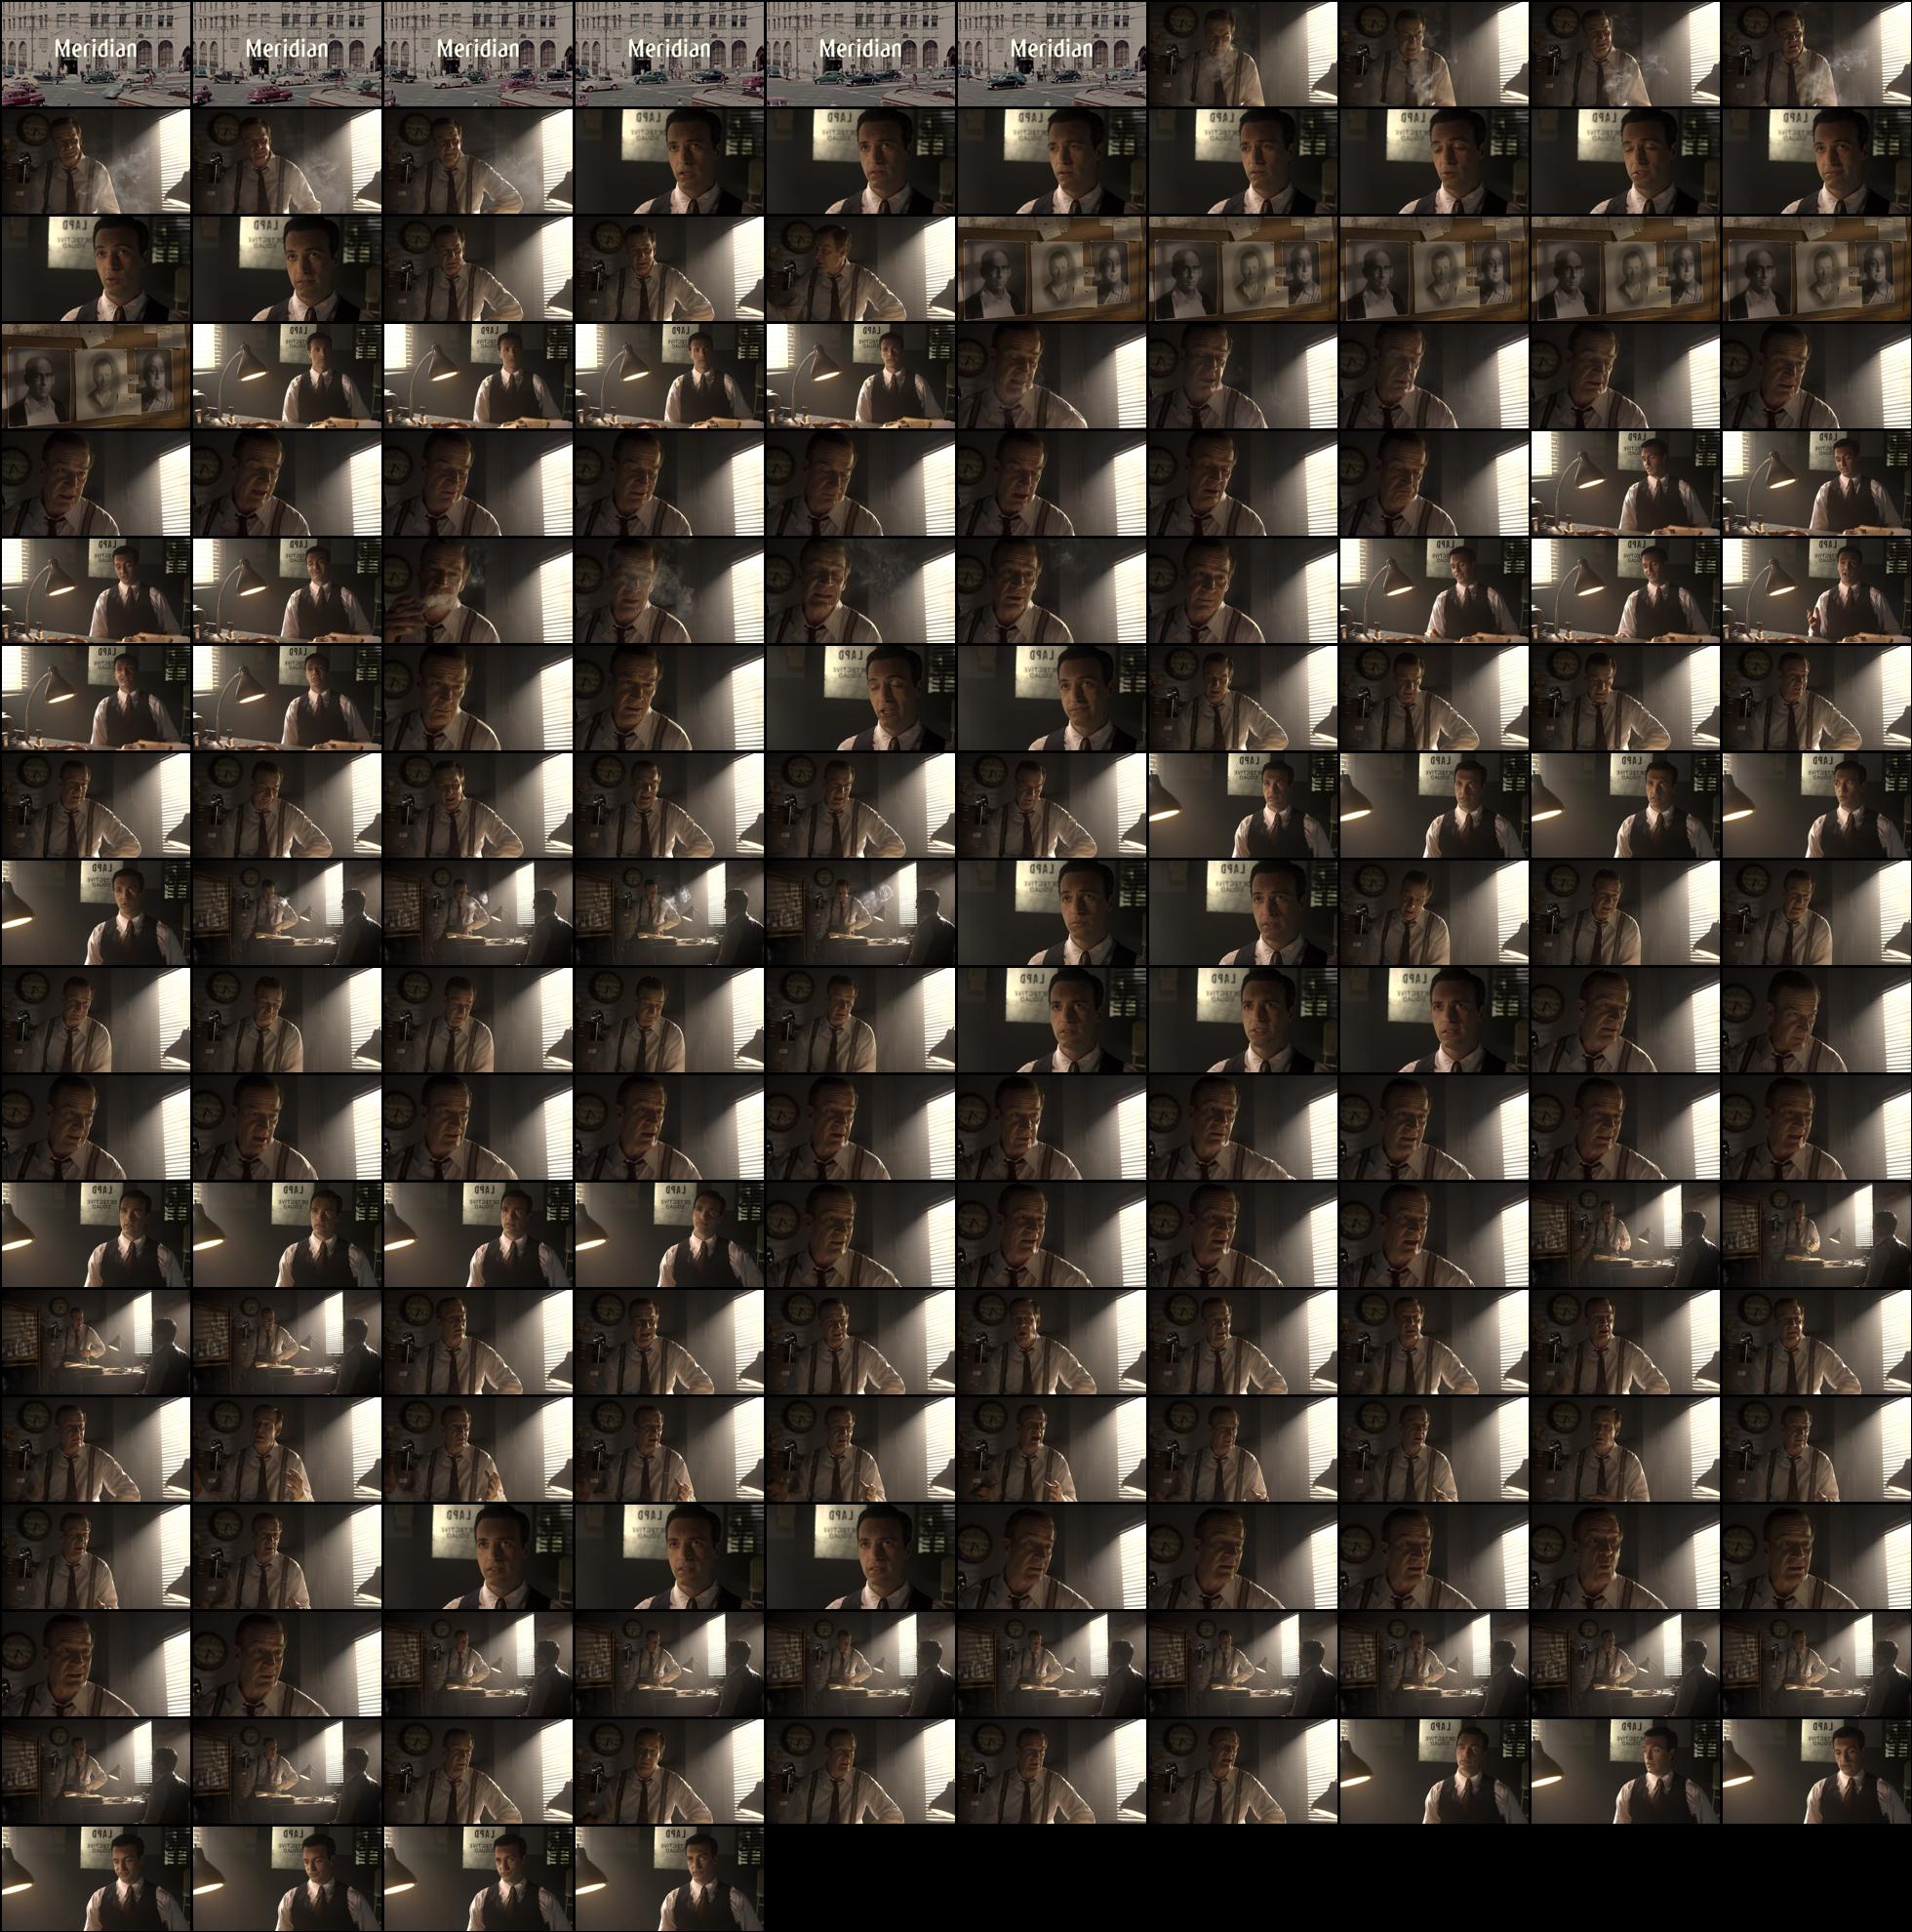

Description: The scene depicts a conversation about the mysterious disappearance of individuals on a specific stretch of road above El Matador. It delves into the backgrounds of the missing persons, their professions, and personal histories. The discussion considers the possibility of suicide but dismisses it due to the absence of bodies and the presence of a witness. The focus then shifts to the witness's account of strange occurrences, including a man on a rock, sudden dark weather, and the appearance of a mysterious woman. (95%)
Sentiment: Neutral (85%)
Iab_taxonomy: Sensitive Topics (90%)
Garm_taxonomy: Debated Sensitive Social Issue (88%)
Brands_and_logos: None
Relevant_tags: disappearance, mystery, witness, strange occurrences, El Matador


==== Chapter #06: Contextual information ======


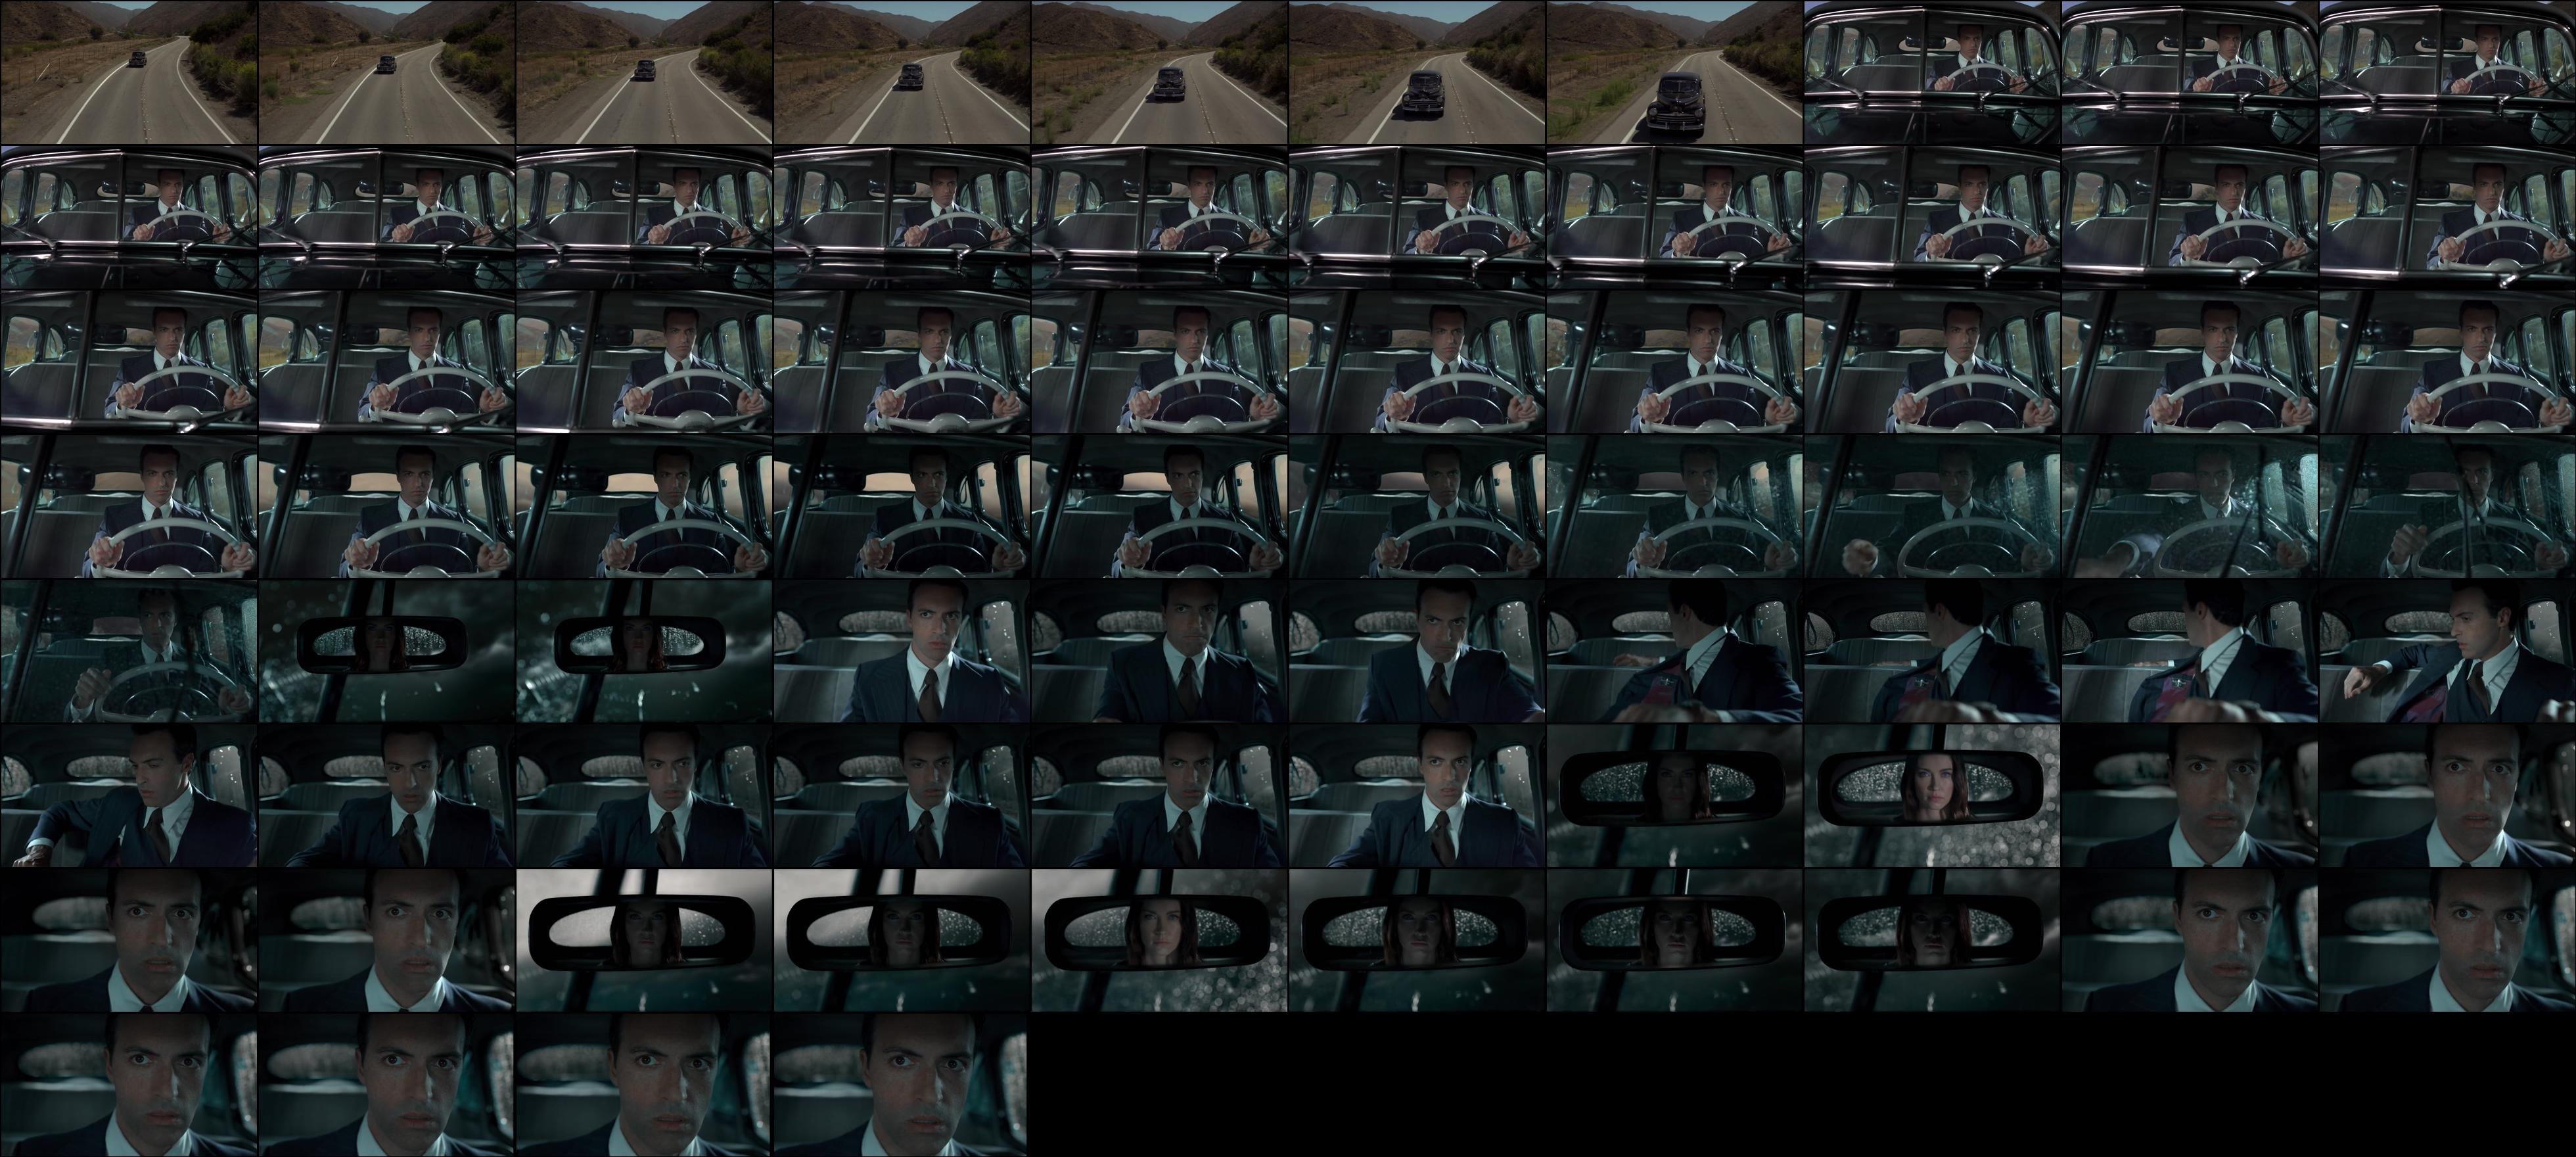

Description: The scene depicts a man driving a car on a highway, with a focus on his face and the steering wheel. The highway is surrounded by a mountainous landscape, and the car is moving at a steady pace. The man appears to be focused on the road ahead, with occasional glances in the rearview mirror. The scene suggests a sense of motion and travel, with the car moving through a scenic environment. (95%)
Sentiment: Neutral (85%)
Iab_taxonomy: Automotive (90%)
Garm_taxonomy: None (95%)
Brands_and_logos: None
Relevant_tags: driving, highway, mountains, travel, automotive


==== Chapter #07: Contextual information ======


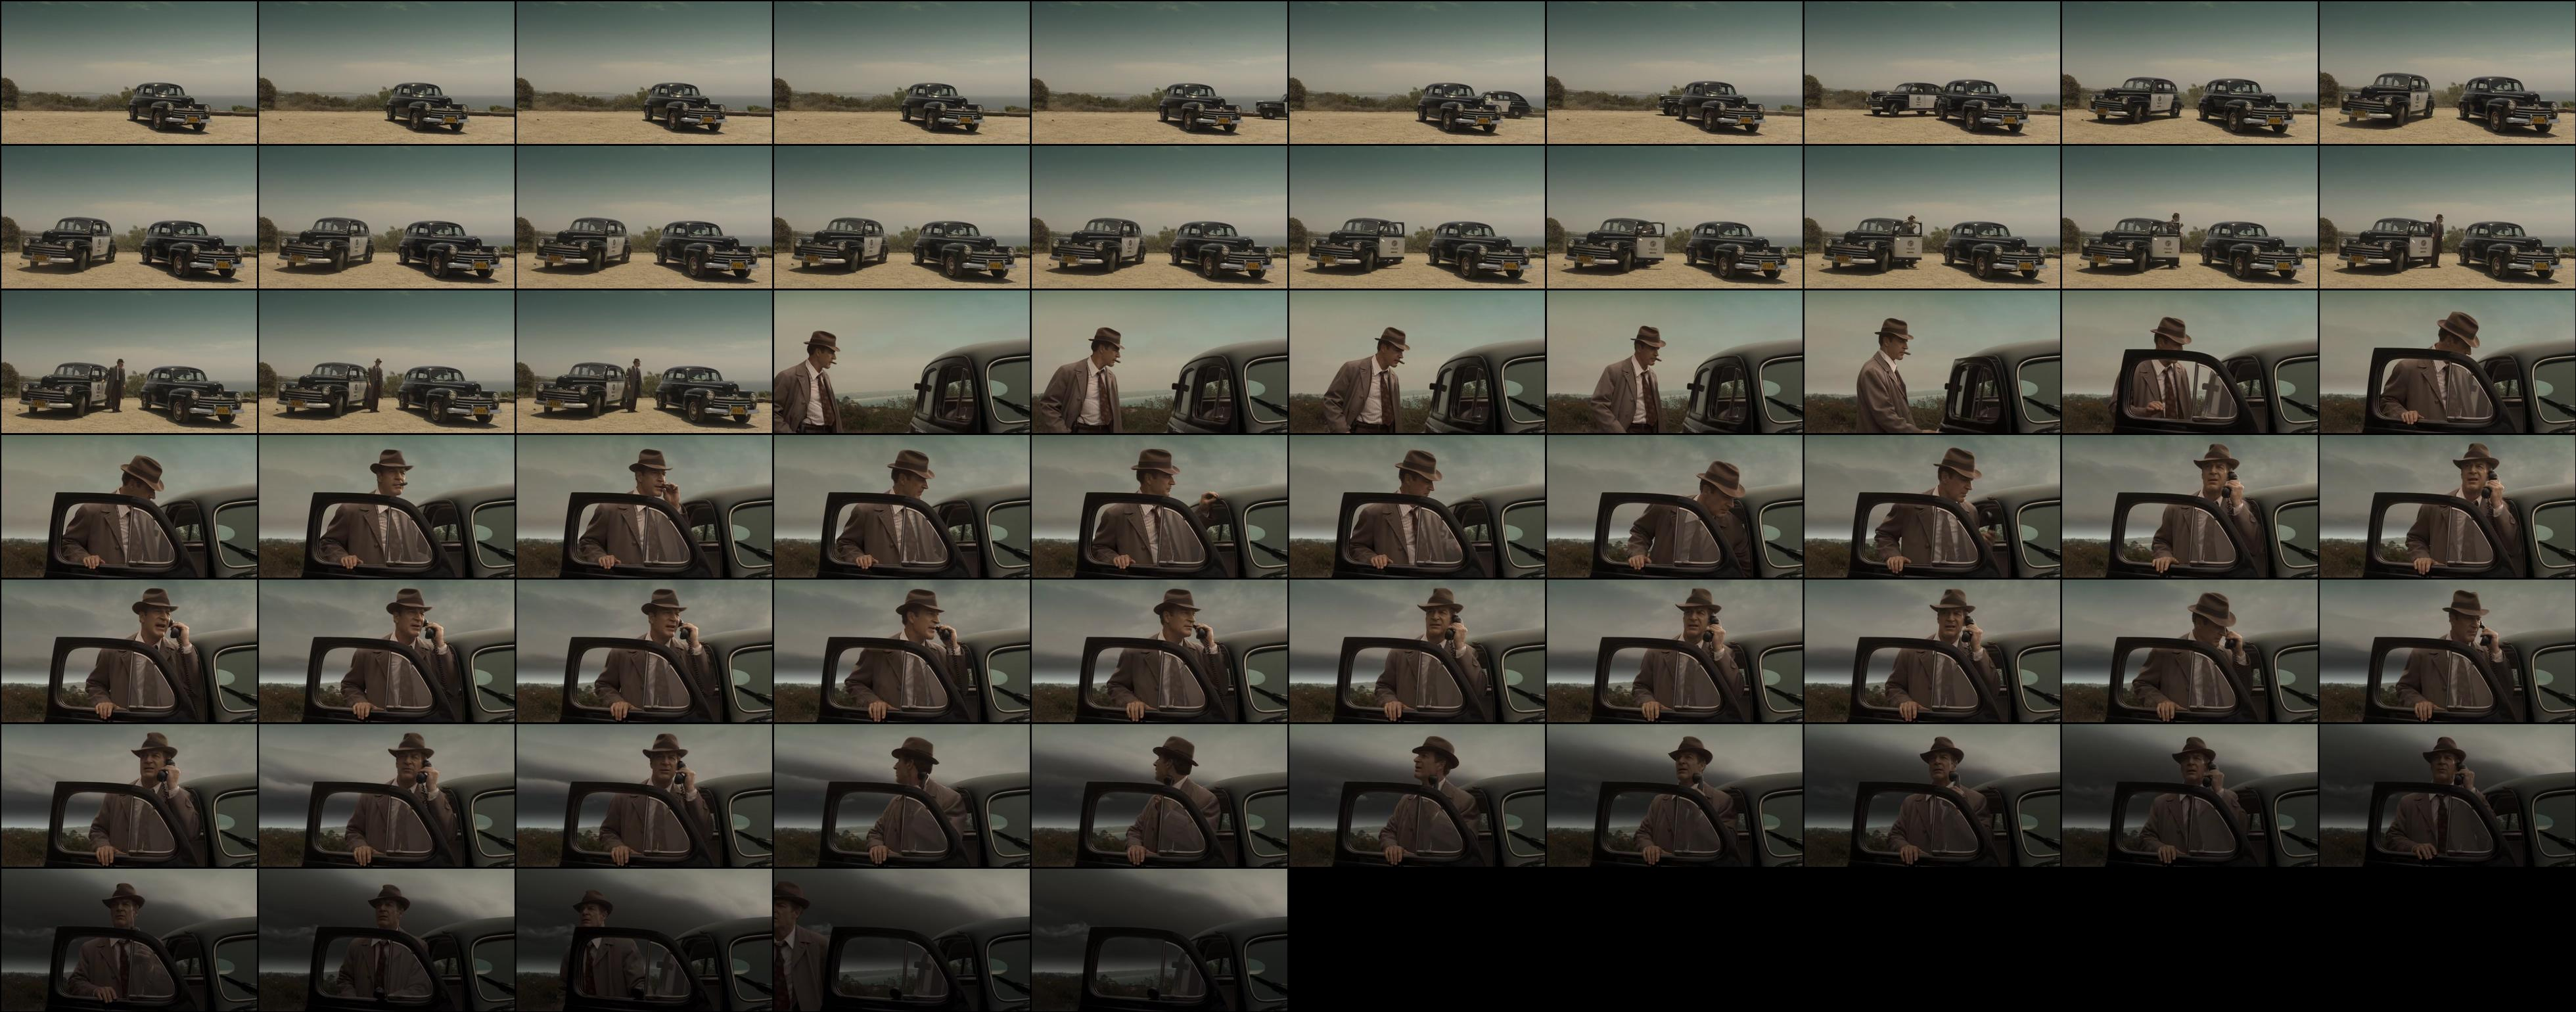

Description: The scene depicts a series of images showing vintage cars, possibly from the 1940s or 1950s, parked in a desert-like setting. The cars are predominantly black, with some having white stripes on the sides. A man dressed in a suit, tie, and hat is seen standing next to one of the cars, holding a telephone to his ear, suggesting he is engaged in a conversation. The background features a cloudy sky and a distant view of the ocean. (95%)
Sentiment: Neutral (85%)
Iab_taxonomy: Automotive (90%)
Garm_taxonomy: None (95%)
Brands_and_logos: None
Relevant_tags: vintage cars, desert setting, 1940s fashion, telephone conversation, ocean view


==== Chapter #08: Contextual information ======


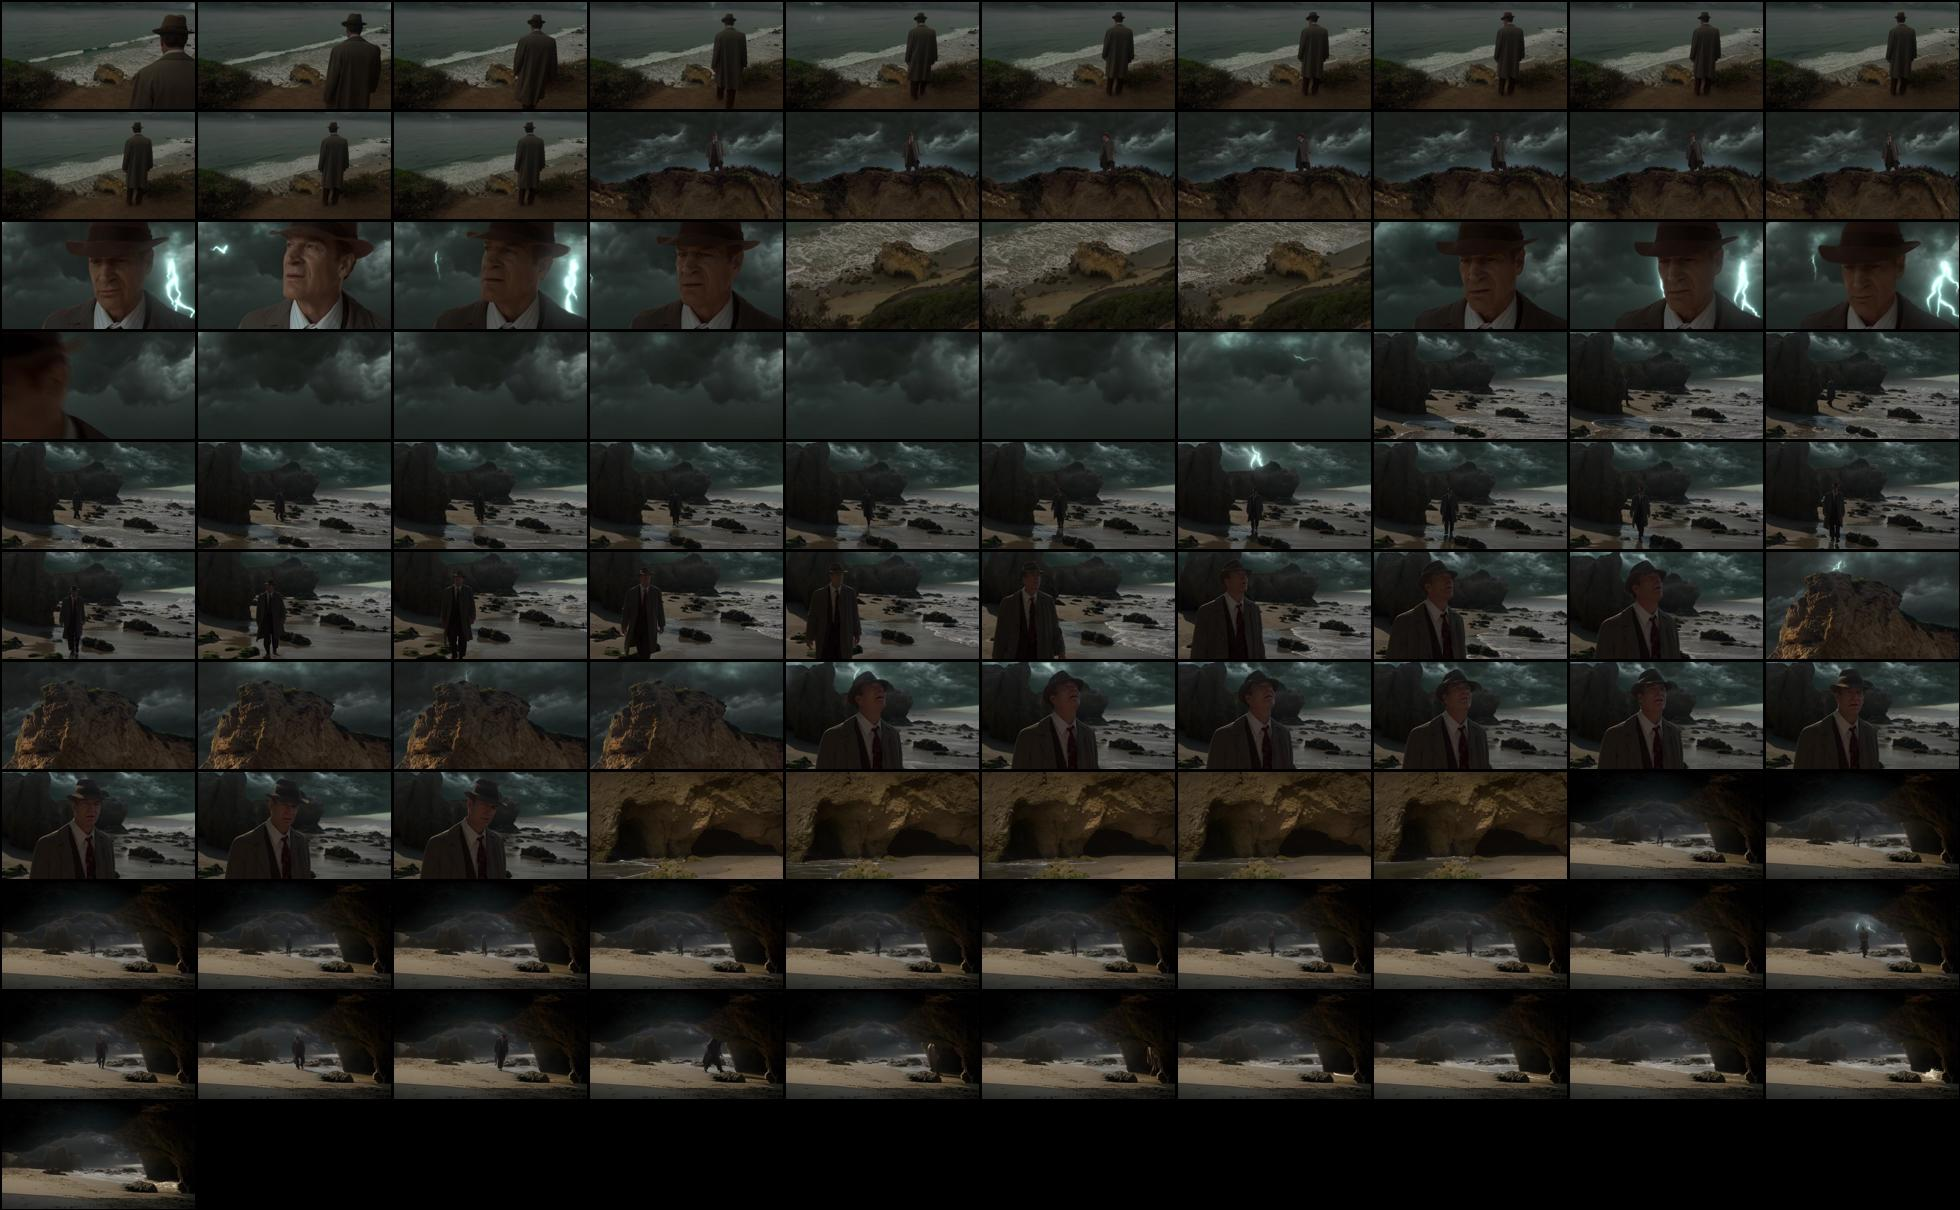

Description: The scene depicts a man, dressed in a suit and hat, walking along a beach under a stormy sky. He appears to be a law enforcement officer, possibly a captain, as he is communicating with dispatch and preparing to investigate the area. The atmosphere is tense and dramatic, with lightning flashing in the background. (95%)
Sentiment: Neutral (85%)
Iab_taxonomy: Law (80%)
Garm_taxonomy: None (90%)
Brands_and_logos: None
Relevant_tags: stormy weather, law enforcement, investigation, beach, lightning


==== Chapter #09: Contextual information ======


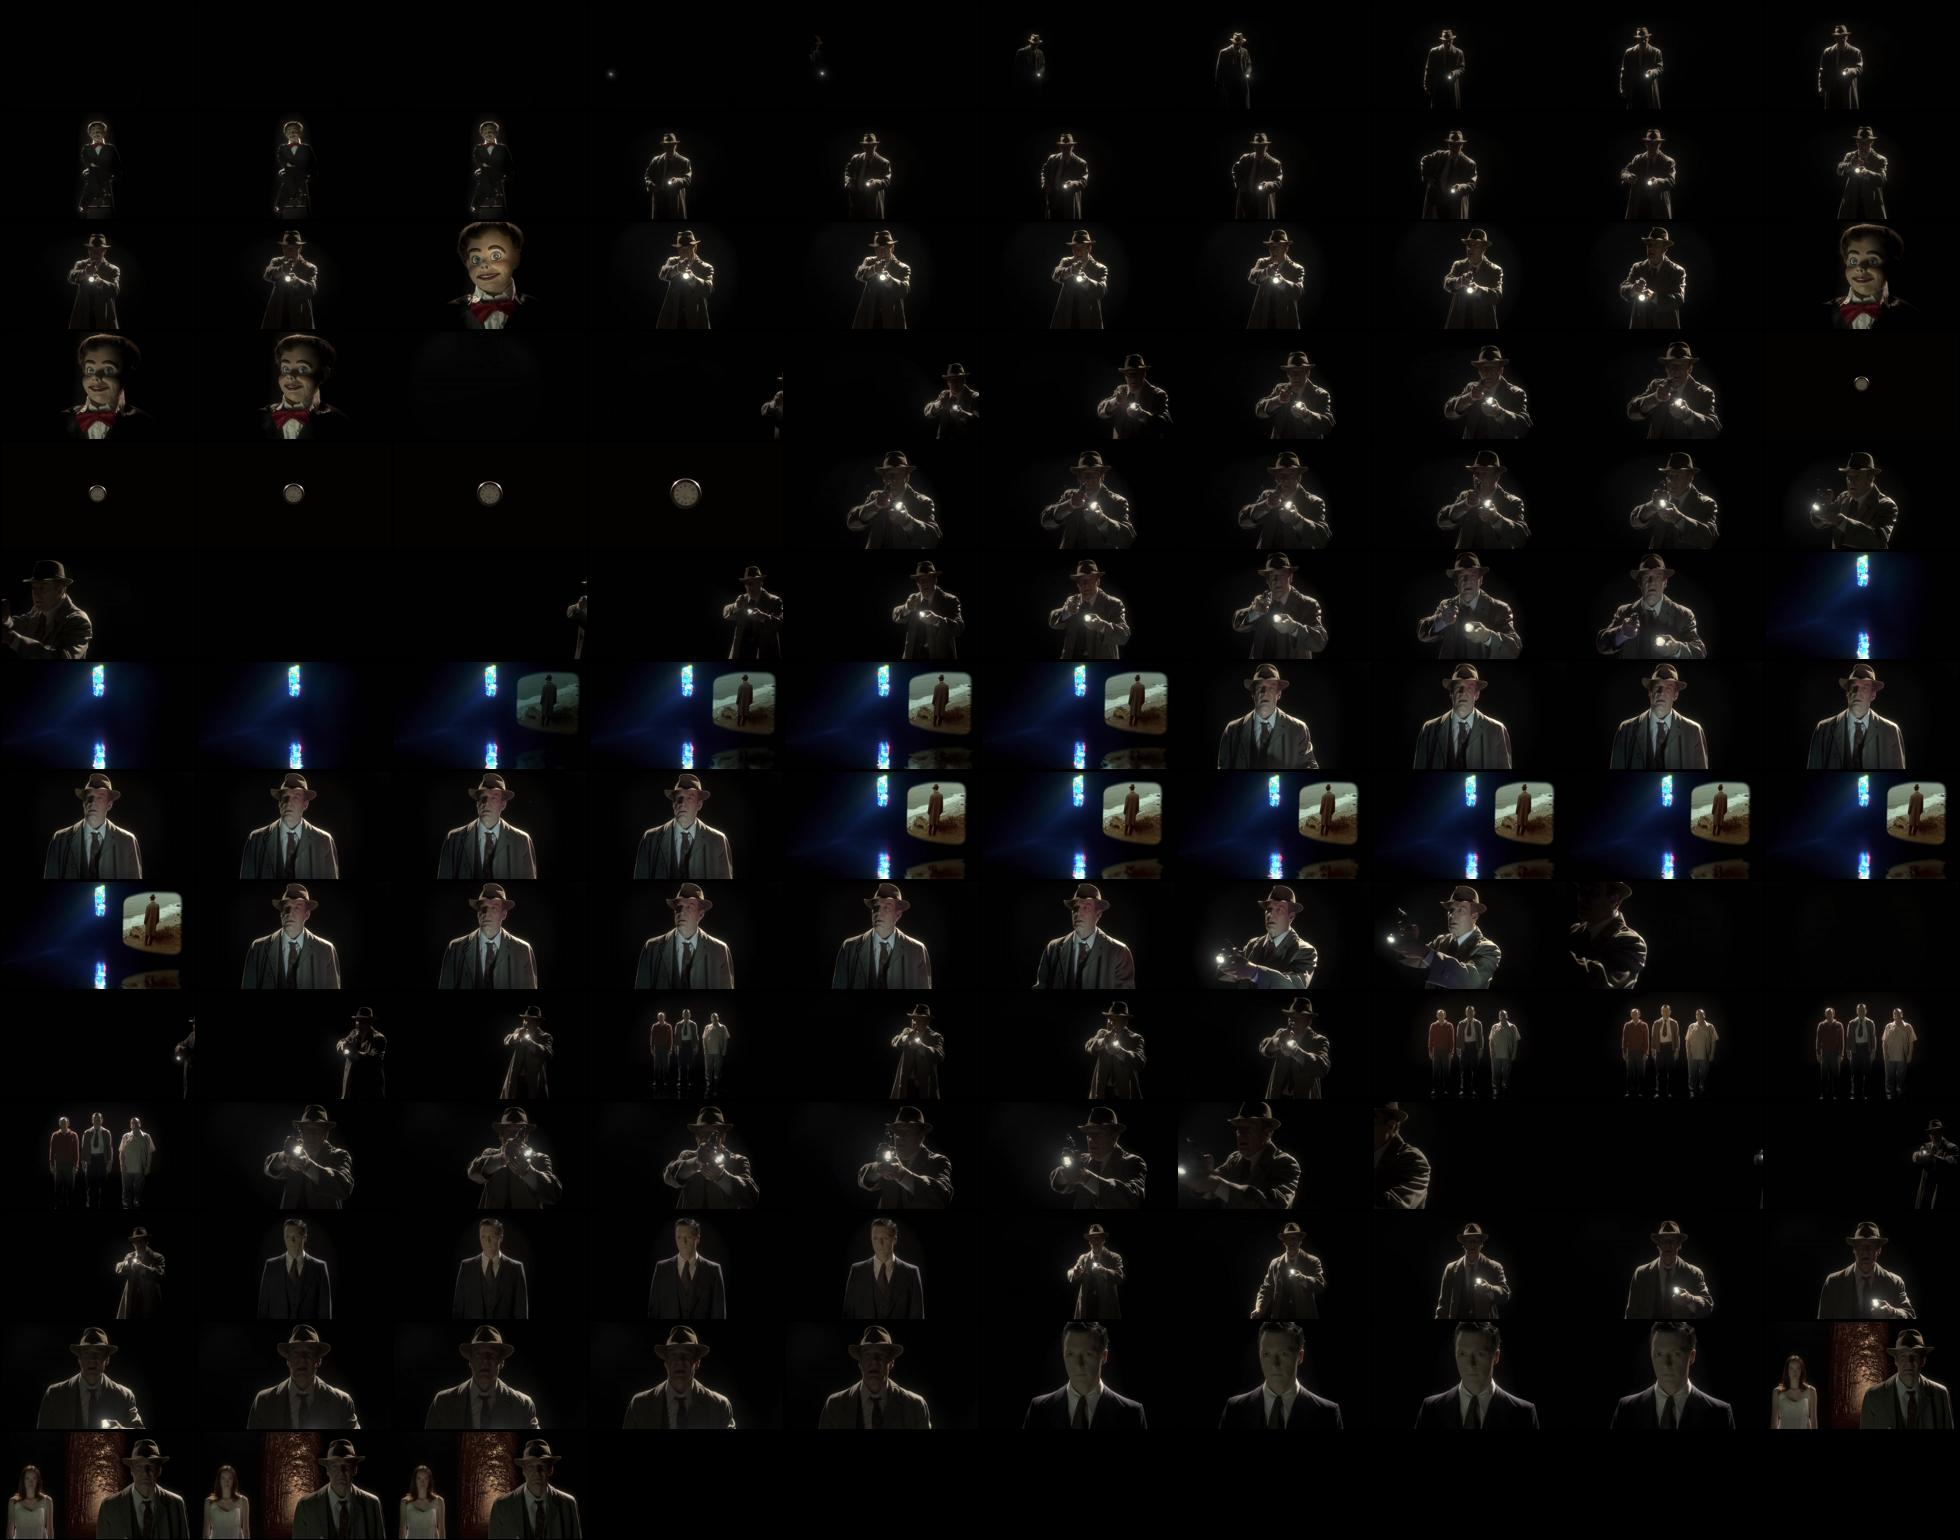

Description: The scene depicts a series of images showing a person in a trench coat and hat holding a flashlight, followed by a person in a suit and tie holding a flashlight, and then a person in a suit and tie holding a gun. The scene then shows a person in a trench coat and hat holding a gun, followed by a person in a suit and tie holding a gun. The scene then shows a person in a trench coat and hat holding a flashlight, followed by a person in a suit and tie holding a flashlight. The scene then shows a person in a trench coat and hat holding a gun, followed by a person in a suit and tie holding a gun. (95%)
Sentiment: Neutral (85%)
Iab_taxonomy: Crime (90%)
Garm_taxonomy: Crime & Harmful acts to individuals and Society, Human Right Violations (88%)
Brands_and_logos: None
Relevant_tags: trench coat, flashlight, suit and tie, gun, confrontation


==== Chapter #10: Contextual information ======


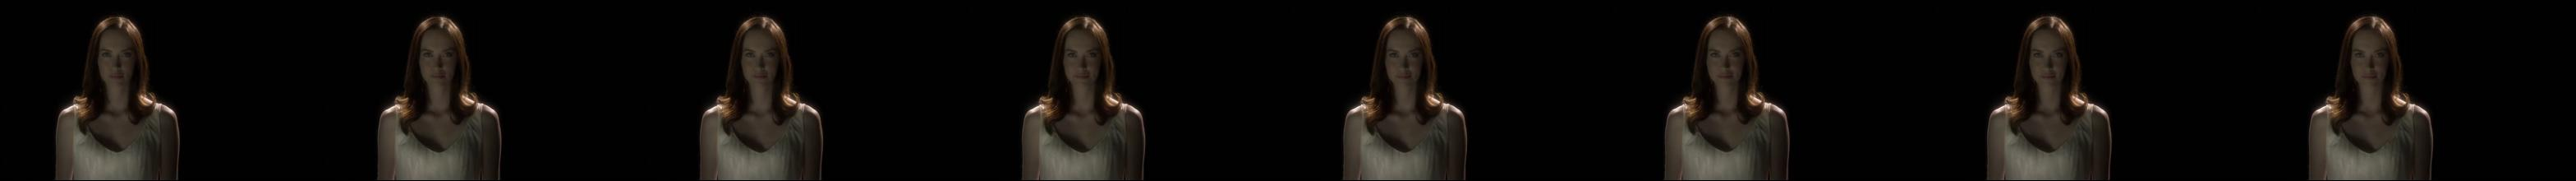

Description: The scene depicts a woman standing in front of a black background. She is wearing a white sleeveless top and has long brown hair. The woman appears to be looking directly at the camera, maintaining a neutral expression throughout the sequence. There are no other objects or actions present in the scene. (95%)
Sentiment: Neutral (90%)
Iab_taxonomy: None (85%)
Garm_taxonomy: None (85%)
Brands_and_logos: None
Relevant_tags: woman, neutral expression, white top, long hair, black background


==== Chapter #11: Contextual information ======


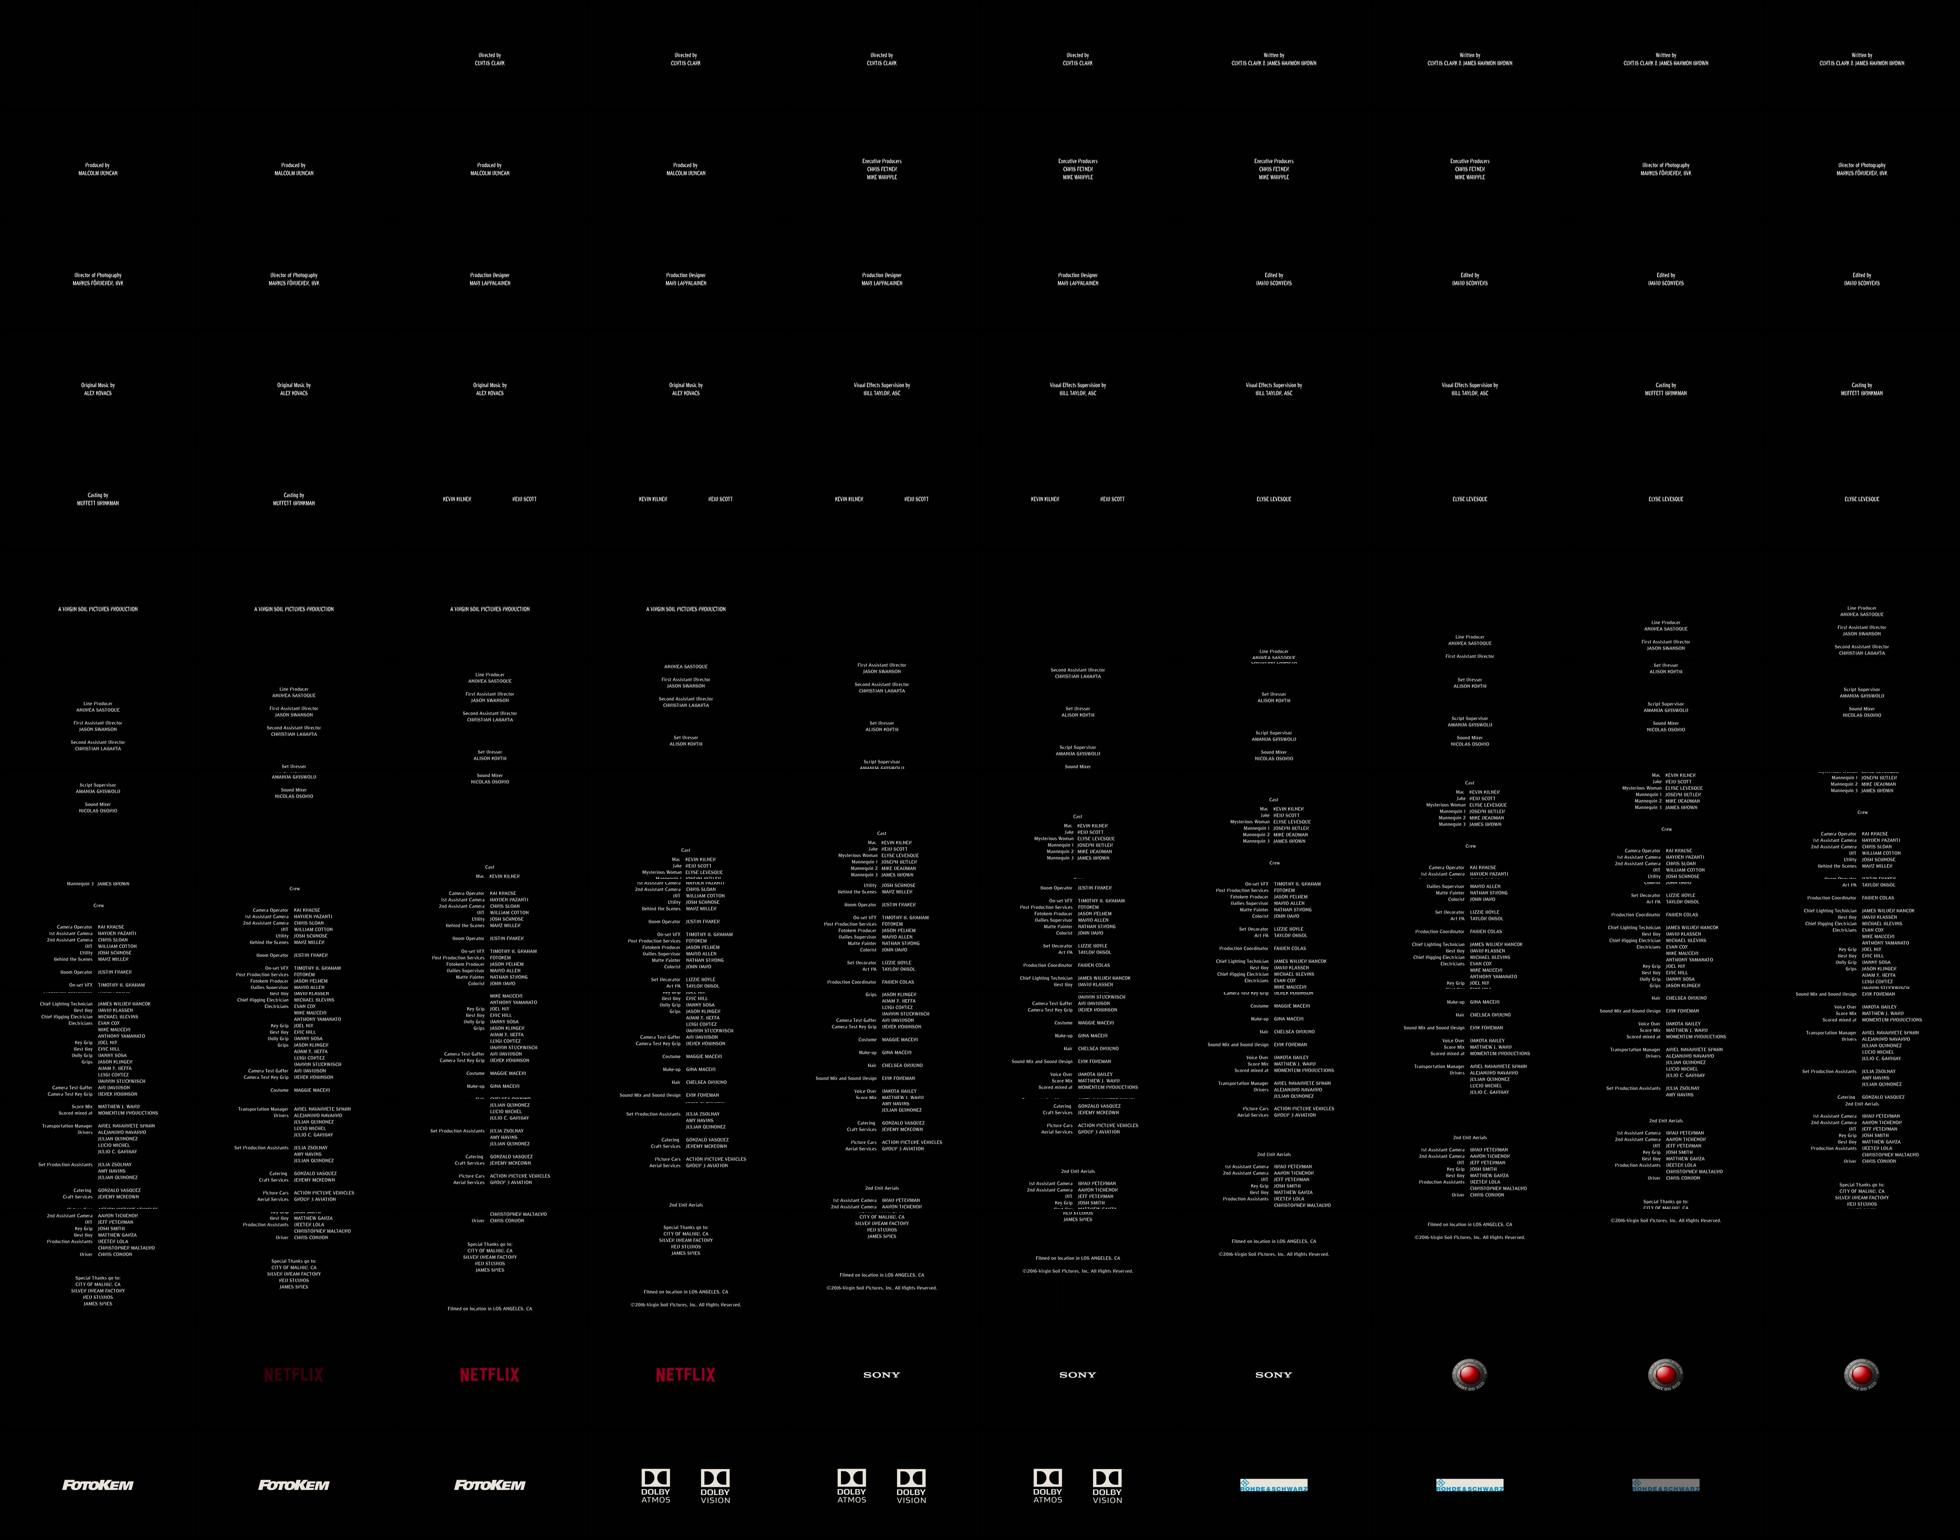

Description: The scene is a list of credits for a film or television production. It includes the names of the director, writers, producers, executive producers, director of photography, production designer, editor, original music composer, visual effects supervisor, casting director, and various other crew members. The production company and filming location are also mentioned. The scene ends with a series of logos for Netflix, Sony, FotoKem, Dolby Atmos, Dolby Vision, and Rohde & Schwarz. (95%)
Sentiment: Neutral (85%)
Iab_taxonomy: Entertainment (90%)
Garm_taxonomy: None (100%)
Brands_and_logos: Netflix, Sony, FotoKem, Dolby Atmos, Dolby Vision, Rohde & Schwarz
Relevant_tags: film credits, production crew, Netflix, Sony, FotoKem




Estimated cost: $0.0 in us-east-1 region with 83950 input tokens and 3756 output tokens.


In [15]:
total_usage = {
    'input_tokens': 0,
    'output_tokens': 0,
}

iab_definitions = load_iab_taxonomy(iab_file)

for chapter in video['chapters'].chapters:

    composite_images = chapter['composite_images']
    num_images = len(composite_images)

    chapter_id = chapter['id']
    text = chapter['text'] 

    contextual_response = get_chapter_description(composite_images, chapter['text'], iab_definitions)
    time.sleep(20)
    usage = contextual_response['usage']
    contextual = contextual_response['content'][0]['json']

    # save the contextual to the chapter
    chapter['contextual'] = {
        'usage': usage,
        **contextual
    }

    if 'input_tokens' in usage:
        total_usage['input_tokens'] += usage['input_tokens']
    else:
        total_usage['input_tokens'] += usage['inputTokens']

    if 'input_tokens' in usage:
        total_usage['output_tokens'] += usage['output_tokens']
    else:
        total_usage['output_tokens'] += usage['outputTokens']

    print(f"==== Chapter #{chapter['id']:02d}: Contextual information ======")
    video['frames'].display_frames(start=chapter['start_frame_id'], end=chapter['end_frame_id']+1)
    for key in ['description', 'sentiment', 'iab_taxonomy', 'garm_taxonomy']:
        print(f"{key.capitalize()}: {colored(contextual[key]['text'], 'green')} ({contextual[key]['score']}%)")

    for key in ['brands_and_logos', 'relevant_tags']:
        items = ', '.join([item['text'] for item in contextual[key]])
        if len(items) == 0:
            items = 'None'
        print(f"{key.capitalize()}: {colored(items, 'green')}")
    print(f"================================================\n\n")

output_file = os.path.join(video["output_dir"], 'scenes_in_chapters.json')
util.save_to_file(output_file, video['chapters'].chapters)

contextual_cost = display_contextual_cost(total_usage, pricing=PRICING)

## Ad breaks

At this point, we have generated video segments that have clear visual breaks between scenes, and we have grouped the scenes into chapters that have clear breaks between topics from the speech in the audio. The breaks between chapters are all candidate ad placement opportunities.  We can use the IAB taxonomy of the chapter segments adjacent to the breaks to make better decisions about what ad to place in that break.  

🤔 As you view the chapter segments, imagine yourself as a company who wants to advertise your brand, are there breaks you prefer over others in terms of brand safety?

🤔 Now imagine you are a viewer.  What products would be interesting if you chose this title?

In practice, ad breaks would be ranked by a value function that takes into account the needs of the consumer, the publisher, and the advertisers.


## Visualize the ad breaks 

In this section, we'll insert a test Ad into one of the breaks to visualize the ad experience.  You can change the value of BREAK_CHAPTER_ID to try different chapter breaks.

In [17]:
import moviepy
from moviepy.editor import VideoFileClip, concatenate_videoclips

BREAK_CHAPTER_ID = 8

ad_demo_file= f"ad_break_{ BREAK_CHAPTER_ID }_demo.mp4"
adbreak_start = video['chapters'].chapters[BREAK_CHAPTER_ID]['start_ms']/1000

clip1 = VideoFileClip(video["path"], target_resolution=(360, 640)).subclip(adbreak_start-10, adbreak_start)
clip2 = VideoFileClip("static/images/CountdownClock_0.mp4", target_resolution=(360, 640))
clip3 = VideoFileClip(video["path"], target_resolution=(360, 640)).subclip(adbreak_start, adbreak_start+10)
final_clip = concatenate_videoclips([clip1,clip2,clip3], method="compose")
final_clip.write_videofile(ad_demo_file)

Moviepy - Building video ad_break_8_demo.mp4.
MoviePy - Writing audio in ad_break_8_demoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video ad_break_8_demo.mp4



Moviepy - Done !
Moviepy - video ready ad_break_8_demo.mp4


In [18]:
Video(url=ad_demo_file, width=640, height=360)

# What's Next?

You can try another use case or, if you are done, continue to the [Additional Resources](09-resources.ipynb) lab.
